In [255]:
import matplotlib
import pandas as pd
import censusdata
import openpyxl
import re
import os
import numpy as np

import matplotlib.pyplot as plt
##### CHECK FOR UNUSED IMPORTS

import sklearn.linear_model

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, train_test_split, validation_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, plot_roc_curve, make_scorer, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, recall_score, ConfusionMatrixDisplay


from yellowbrick.classifier import ROCAUC
from yellowbrick.regressor import PredictionError, ResidualsPlot


import seaborn as sns

import category_encoders as ce

from icecream import ic

import geopandas as gpd

In [435]:
harvard_data = pd.read_csv('196slers1967to2016_20180908.tab', delimiter='\t')
# election_data_merged = pd.read_csv('ny_thru_2018.csv', index_col=0)
harvard_data

,Unnamed: 0,year,cand,party,exper,vote,district
0,238120,2012.0,"thiele, fred w. jr.",democratic,inc,38005.0,l001
1,239258,2014.0,"thiele, fred w. jr.",democratic,inc,19956.0,l001
2,240067,2016.0,"thiele, fred w. jr.",democratic,inc,35246.0,l001
3,238123,2012.0,"deegan, nicholas f.",democratic,none,18159.0,l002
4,238126,2012.0,"losquadro, daniel p.",modernrepublican,inc,34305.0,l002
...,...,...,...,...,...,...,...
1859,1,2020.0,Joseph M. Giglio (REP),modernrepublican,inc,39964.0,l148
1860,0,2020.0,Jonathan D. Rivera (DEM),democratic,none,38611.0,l149
1861,1,2020.0,Joseph Totaro (REP),modernrepublican,none,19922.0,l149
1862,0,2020.0,Christina Cardinale (DEM),democratic,none,17845.0,l150


In [376]:
# harvard_data = pd.read_csv('harvard_data_2010+.csv', index_col=0)
# harvard_data

In [432]:
election_data = harvard_data[(harvard_data['year'] >= 2000)][['year', 'sab', 'ddez', 'sen', 'dtype', 'etype', 'cand', 'party', 'exper', 'vote', 'outcome']]

KeyError: "['sab', 'ddez', 'sen', 'dtype', 'etype', 'outcome'] not in index"

In [ ]:
election_data[election_data['sab'] == 'wv']

In [ ]:
county_results = election_data[(election_data['cand'] != 'scattering') & (election_data['etype'] == 'g')&(election_data.drop('vote', axis=1).duplicated(keep=False))].dropna(subset=['vote'])
county_results

A large number of races (but not every race) has results split by county as confirmed by a spot check of the above data displaying duplicates in candidate name, year, state, and district. They need to be merged.

In [ ]:
county_results.loc[378331].values

In [ ]:
pd.Series(index=county_results.loc[3730].index)

In [ ]:
if (county_results.loc[378331].drop('vote').values == county_results.loc[378330].drop('vote').values).all():
    print('poo')

In [ ]:
np.sort(np.array(county_results.index))

In [ ]:
# election_data.drop(county_results.index)

county_results = county_results.sort_values(['cand', 'year', 'sab', 'ddez', 'sen'])

previous_row = pd.Series(index=county_results.loc[3730].drop(['vote']).index)
vote_total = 0

merged_df = pd.DataFrame()

for i in np.sort(np.array(county_results.index)):
#     print(i)
    if (county_results.loc[i].drop('vote') == previous_row).all():
#         print(county_results.loc[i])
        vote_total += county_results.loc[i]['vote']
        previous_row = county_results.loc[i].drop('vote')
    else:
        previous_row['vote'] = vote_total
        previous_row['original_index'] = i
        merged_df = merged_df.append(previous_row, ignore_index=True)
        
        vote_total = county_results.loc[i]['vote']
        previous_row = county_results.loc[i].drop('vote')
#     print(merged_df)
#     input()
merged_df.head(20)

In [ ]:
merged_df[merged_df['cand'] == 'betterton, andew (andy)']

In [ ]:
election_data_merged = pd.concat([merged_df[1:], election_data.drop(county_results.index)])

election_data_merged

In [ ]:
election_data_merged[(election_data_merged['cand'] != 'scattering') & (election_data_merged['etype'] == 'g')&(election_data_merged.drop('vote', axis=1).duplicated(keep=False))].dropna(subset=['vote'])

In [ ]:
election_data_merged

# Likely remove in favor of previous winner party

Prior columns are useless for this segment of data though incumbency (expr column) is going to be a huge indicator obviously. For this research I'm going to limit to general elections. Then I'm going to need to combine candidates due to NY's fusion voting system.

In [ ]:
election_data_merged = election_data_merged[election_data_merged['etype'] == 'g']
election_data_merged = election_data_merged[['year', 'sab', 'ddez', 'sen', 'cand', 'party', 'exper', 'vote', 'outcome']]
election_data_merged

In [ ]:
list_of_candidates = election_data_merged['cand'].unique()

list_of_candidates

In [ ]:
election_data_merged['year'].value_counts()

In [ ]:
election_data_merged[election_data_merged['cand'] == 'thiele, fred w. jr.'].groupby(['year']).sum()

In [ ]:
election_data_merged['district'] = election_data_merged.apply(lambda row: ('u' if row['sen'] == 1 else 'l') + '{:0>3}'.format(row['ddez']), axis=1)
election_data_merged

In [ ]:
election_data_merged[(election_data_merged['year'] == 2014) & (election_data_merged['ddez'] == '7-B')]

In [ ]:
sorted([str(x) for x in election_data_merged['party'].unique()])

In [ ]:
republican = ['republican','republican/independent','republicanwritein', 'writeinrepublican', 'modernrepublican', 'independentrepublicanparty', 'independentrepublican', 'gop/independentparty', 'independentandrepublican']

democratic = [ 'progressive/democratic/workingfamily',
              'progressive/democratic',
              'progressivedemocrat',
              'writeindemocrat',
              'independentanddemocrat',
             'independentdemocrat',
             'independentdemparty','democrat',
             'democrat/progressive',
             'democrat/workingfamilies',
             'democratfarmerlabor',
             'democratic',
             'democratic/progressive',
             'democraticfarmerlabor',
             'democraticparty',
             'democraticwritein',
             'democratparty'
            ]

In [ ]:
election_data_merged[election_data_merged['party'] == 'democraticrepublican']

In [ ]:
election_data_merged[election_data_merged['party'] == 'democratandrepublican']

In [ ]:
election_data_merged.loc[211815:211825]

In [ ]:
election_data_merged[election_data_merged['party'] == 'democratic/republican']

In [ ]:
election_data_merged = election_data_merged.sort_index()

In [ ]:
election_data_merged.loc[343115:343130]

Mixed democrats and republicans

As far as I can tell all democratic republican combinations are cross endorsed. Elections where they appear should be removed from dataset.

In [ ]:
election_data_merged[election_data_merged['party'] == 'democraticwritein']

In [ ]:
election_data_merged.loc[372034:372049]

Let's count democraticwritein ONLY when there's no democrat or democratic-republican candidate. Count republicanwritein ONLY when there's no republican or democratic-republican candidate.

Need to combine rows so each row represents one general election. Vote feature should be net democratic votes


In [ ]:
# need to include outcome because we can't simply rely on vote totals because a number of new england states have multimember districts

election_data_merged = election_data_merged[['year', 'sab', 'cand', 'party', 'exper', 'vote', 'outcome', 'district']]
election_data_merged

In [ ]:
election_data_merged['exper'].value_counts()

In [ ]:
election_data_merged['sab'].value_counts()

In [ ]:
election_data_merged['outcome'].value_counts()

In [ ]:
election_data_merged[(election_data_merged['sab'] == 'nh') & (election_data_merged['district'].str.startswith('l')) & (election_data_merged['outcome'] == 'w')].head(20)

In [ ]:
election_data_merged[election_data_merged['district'] == 'lBelknap 2']

Approaches to dealing with multimember districts
 - treat each seat as seperate district *
 - exclude all multimember districts

In [440]:
election_data_merged

,year,cand,party,exper,vote,district,sab
238120,2012.0,"thiele, fred w. jr.",democratic,inc,38005.0,l001,ny
239258,2014.0,"thiele, fred w. jr.",democratic,inc,19956.0,l001,ny
240067,2016.0,"thiele, fred w. jr.",democratic,inc,35246.0,l001,ny
238123,2012.0,"deegan, nicholas f.",democratic,none,18159.0,l002,ny
238126,2012.0,"losquadro, daniel p.",modernrepublican,inc,34305.0,l002,ny
...,...,...,...,...,...,...,...
1,2020.0,Joseph M. Giglio (REP),modernrepublican,inc,39964.0,l148,ny
0,2020.0,Jonathan D. Rivera (DEM),democratic,none,38611.0,l149,ny
1,2020.0,Joseph Totaro (REP),modernrepublican,none,19922.0,l149,ny
0,2020.0,Christina Cardinale (DEM),democratic,none,17845.0,l150,ny


In [ ]:
party_map = {}

for each in democratic:
    party_map[each] = 'democratic'
for each in republican:
    party_map[each] = 'republican'

In [ ]:
election_data_merged['party'] = election_data_merged['party'].map(party_map)

In [441]:
# shows bias towards learning about democrats as in some cases republicans and 3rd party candidates are grouped together

years = [2011, 2012, 2013, 2014, 2015, 2016]
# districts = election_data_merged['district'].unique()
# states = election_data_merged['sab'].unique()
final_election_data = pd.DataFrame()

for year in years:
    for state in ['ny']:
        districts = election_data_merged[(election_data_merged['sab'] == state) & (election_data_merged['year'] == year)]['district'].unique()
        for district in districts:
            election = election_data_merged[(election_data_merged['year'] == year) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district) & (election_data_merged['party'].isin(democratic+republican))]
            if election.empty or 'w' not in election['outcome'].unique() or len(election['party'].unique()) == 1:
                pass
            else:
#                 print(year, state, district)
                num_of_seats = election['outcome'].value_counts()['w']
                if len(election) < num_of_seats * 2 or (num_of_seats != election['party'].isin(republican).value_counts()[True] or num_of_seats != election['party'].isin(democratic).value_counts()[True]):
                    pass
                else:
                    for seat in range(num_of_seats):
                        dem_net_vote = election[election['party'].isin(democratic)].iloc[seat]['vote'] - election[election['party'].isin(republican)].iloc[seat]['vote']
                        dem_incumbent = election[election['party'].isin(democratic)]['exper'].iloc[0]
                        if dem_incumbent == 'inc':
                            dem_incumbent = True
                        else:
                            dem_incumbent = False
                        rep_incumbent = election[election['party'].isin(republican)]['exper'].iloc[0]
                        if rep_incumbent == 'inc':
                            rep_incumbent = True
                        else:
                            rep_incumbent = False
                            
                        if dem_incumbent == True:
                            previous_winner_dem = True
                        elif rep_incumbent == True:
                            previous_winner_dem = False
                        else:
#                             try:
                            if year -2 > 2010:
                                prev_election = election_data_merged[(election_data_merged['year'] == year - 2) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district)]
                                if prev_election.empty:
                                    if year-4 > 2010:
                                        prev_election = election_data_merged[(election_data_merged['year'] == year - 4) & (election_data_merged['sab'] == state) & (election_data_merged['district'] == district)]
                                        if prev_election.empty:
                                            previous_winner_dem = np.nan
                                        elif prev_election[(prev_election['party'].isin(democratic+republican))].empty:
                                            previous_winner_dem = np.nan
                                        else:
            #                                 prev_num_of_seats = prev_election['outcome'].value_counts()['w']
                                            if len(prev_election[prev_election['outcome'] == 'w'])-1 < seat:
                                                previous_winner_dem = np.nan
                                            else:
                                                party_of_prev_winner = prev_election[prev_election['outcome'] == 'w'].iloc[seat]['party']
                                            if party_of_prev_winner in democratic:
                                                previous_winner_dem = True
                                            elif party_of_prev_winner in republican:
                                                previous_winner_dem = False
                                    elif prev_election[(prev_election['party'].isin(democratic+republican))].empty:
                                        previous_winner_dem = np.nan
                                    else:
        #                                 prev_num_of_seats = prev_election['outcome'].value_counts()['w']
                                        if len(prev_election[prev_election['outcome'] == 'w'])-1 < seat:
                                            previous_winner_dem = np.nan
                                        else:
                                            party_of_prev_winner = prev_election[prev_election['outcome'] == 'w'].iloc[seat]['party']
                                            if party_of_prev_winner in democratic:
                                                previous_winner_dem = True
                                            elif party_of_prev_winner in republican:
                                                previous_winner_dem = False
                                            else:
                                                if len(prev_election[prev_election['outcome'] == 'l'])-1 < seat:
                                                    previous_winner_dem = np.nan
                                                else:
                                                    if prev_election[prev_election['outcome'] == 'l'].iloc[seat]['party'] in democratic:
                                                        previous_winner_dem = False
                                                    else:
                                                        previous_winner_dem = np.nan
#                                         previous_winner_dem = np.nan
#                             except:
#                                 previous_winner_dem = np.nan

                    final_election_data = final_election_data.append({'year': year,
                                            'state': state,
                                            'temp_district': district,
                                            'district': district + '-' + str(seat),
                                            'dem_net_vote': dem_net_vote,
                                            'previous_winner_dem': previous_winner_dem
#                                             'dem_incumbent': dem_incumbent,
#                                             'rep_incumbent': rep_incumbent
                                           }, ignore_index=True)

final_election_data

KeyError: 'outcome'

In [ ]:
# previous_winner_df = pd.DataFrame()
# years = final_election_data.year.unique()
# districts = final_election_data.district.unique()

# for year in years:
#     for district in districts:
#         row = {}
#         election = final_election_data[['dem_net_vote', 'dem_incumbent', 'rep_incumbent']][(final_election_data['year'] == year) & (final_election_data['district'] == district)]
#         if election.empty:
#             pass
#         else:
#             if election['dem_incumbent'].iloc[0] == 1.0:
#                 previous_winner_dem = True
#             elif election['rep_incumbent'].iloc[0] == 1.0:
#                 previous_winner_dem = False
#             else:
#                 try:
#                     if final_election_data[(final_election_data['year'] == year-2) & (final_election_data['district'] == district) & (final_election_data['sab'] == )]['dem_net_vote'].iloc[0] > 0:
#                         previous_winner_dem = True
#                     else:
#                         previous_winner_dem = False
#                 except:
#                     previous_winner_dem = np.nan
# #             row['dem_net_vote'] = election['dem_net_vote'].iloc[0]

#             previous_winner_df = previous_winner_df.append({'previous_winner_dem': previous_winner_dem, 'year': year, 'district': district}, ignore_index=True)
                

In [ ]:
# previous_winner_df

In [ ]:
# final_election_data = pd.merge(left = final_election_data,
#          right = previous_winner_df,
#          how='left',
#          on=['year', 'district']
#         )

In [ ]:
# final_election_data

In [ ]:
final_election_data[final_election_data['previous_winner_dem'].isna()]

In [ ]:
final_election_data[(final_election_data['dem_net_vote']>0) &(final_election_data['previous_winner_dem'] == 0)]

In [ ]:
final_election_data[(final_election_data['dem_net_vote']>0) &(final_election_data['previous_winner_dem'] == 1)]

In [ ]:
final_election_data[(final_election_data['dem_net_vote']<0) &(final_election_data['previous_winner_dem'] == 1)]

In [ ]:
final_election_data[(final_election_data['dem_net_vote']<0) &(final_election_data['previous_winner_dem'] == 0)]

In [ ]:
final_election_data

In [ ]:
final_election_data

In [ ]:
final_election_data = final_election_data.dropna()
final_election_data

In [ ]:
for each in final_election_data['year'].value_counts().index:
    print(str(each)[0:2])

In [ ]:
'l26-B'.replace('-', '')

'l' + '{:0>2}'.format('l26-B'[1:-2]) + 'l26-B'[-1]

In [ ]:
final_election_data['census_matching_temp_district'] = final_election_data.apply(lambda row: 'l' + '{:0>3}'.format(row['temp_district'][1:-2]) if row['temp_district'][0] == 'l' and row['state'] == 'id' else 
                          (row['temp_district'][0]+'{:0>2}'.format(row['temp_district'][1:2]) + row['temp_district'][-1] if row['temp_district'][0] == 'l' and row['state'] == 'mn' else 
                           (row['temp_district'][:-2] + row['temp_district'][-1] if row['temp_district'][-1] in ['A', 'B'] and row['state'] == 'sd' else 
#                             (row['temp_district'].split()[0][0] + '{:0>3}'.format(row['temp_district'].split()[1]) if row['temp_district'][0] == 'l' and row['state'] == 'wa' else 
                            (row['temp_district'][0] + '{:0>3}'.format(row['temp_district'][1]) if row['temp_district'][0] == 'l' and row['state'] == 'wa' else 
                         (row['temp_district'][0]+'{:0>3}'.format(row['temp_district'][1:-2]) if row['temp_district'][-2] == '-' and row['state'] == 'wv' else 
                          ('l' + '{:0>2}'.format(row['temp_district'][1:-2]) + row['temp_district'][-1]  if row['temp_district'][-1] in ['A', 'B', 'C'] and row['state'] == 'md' else 
                           (row['temp_district'].replace('lGrandisle', 'lGrand-Isle') if row['temp_district'][:10] == 'lGrandisle' and row['state'] == 'vt' else 
                            (row['temp_district'].replace(' ', '-') if row['temp_district'][0] == 'l' and row['state'] == 'vt' else row['temp_district']))))))), axis=1)

In [ ]:
values_to_grab = {'B01001001': "Total Pop",
                  'B01001002': "Male",
                  'B01001026': "Female",
                  'B02001002':"White alone",
                  'B02001003':"Black or African American alone",
                  'B02001004':"American Indian and Alaska Native alone",
                  'B02001005':"Asian alone",
                  'B02001006':"Native Hawaiian and Other Pacific Islander alone",
                  'B02001007':"Some other race alone",
                  'B02001008':"Two or more races:",
                  'B02001009':"Two races including Some other race",
                  'B02001010':"Two races excluding Some other race, and three or more races",
                  'B05001002':"U.S. citizen, born in the United States",
                  'B05001003':"U.S. citizen, born in Puerto Rico or U.S. Island Areas",
                  "B06007002":"Speak only English",
                  "B06007003":"Speak Spanish",
                  "B06007006":"Speak other languages",
                  "B06008002":"Never married",
                  "B06008003":"Now married, except separated",
                  "B06008004":"Divorced",
                  "B06008005":"Separated",
                  "B06008006":"Widowed",
                  "B06009002":"Less than high school graduate",
                  "B06009003":"High school graduate (includes equivalency)",
                  "B06009004":"Some college or associate's degree",
                  "B06009005":"Bachelor's degree",
                  "B06009006":"Graduate or professional degree",
                  "B06010002":"No income",
                  "B06010004":"$1 to $9,999 or loss",
                  "B06010005":"$10,000 to $14,999",
                  "B06010006":"$15,000 to $24,999",
                  "B06010007":"$25,000 to $34,999",
                  "B06010008":"$35,000 to $49,999",
                  "B06010009":"$50,000 to $64,999",
                  "B06010010":"$65,000 to $74,999",
                  "B06010011":"$75,000 or more",
                  "B16004002":"5 to 17 years",
                  "B16004024":"18 to 64 years",
                  "B16004046":"65 years and over"








}

In [378]:
ordinal_dict = {
    '1st': 'First',
    '2nd': 'Second',
    '3rd': 'Third',
    '4th': 'Fourth',
    '5th': 'Fifth',
    '6th': 'Sixth',
    '7th': 'Seventh',
    '8th': 'Eighth',
    '9th': 'Ninth',
    '10th': 'Tenth',
    '11th': 'Eleventh',
    '12th': 'Twelfth',
    '13th': 'Thirteenth',
    '14th': 'Fourteenth',
    '15th': 'Fifteenth',
    '16th': 'Sixteenth',
    '17th': 'Seventeenth',
    '18th': 'Eighteenth',
    '19th': 'Nineteenth',
    '20th': 'Twentieth',
    '21st': 'Twenty-First',
    '22nd': 'Twenty-Second',
    '23rd': 'Twenty-Third',
    '24th': 'Twenty-Fourth',
    '25th': 'Twenty-Fifth',
    '26th': 'Twenty-Sixth',
    '27th': 'Twenty-Seventh',
    '28th': 'Twenty-Eighth',
    '29th': 'Twenty-Ninth',
    '30th': 'Thirtieth',
    '31st': 'Thirty-First',
    '32nd': 'Thirty-Second',
    '33rd': 'Thirty-Third',
    '34th': 'Thirty-Fourth',
    '35th': 'Thirty-Fifth',
    '36th': 'Thirty-Sixth',
    '37th': 'Thirty-Seventh'
}

In [379]:
states = {
'28': ["Mississippi","ms"],
'29': ["Missouri","mo"],
'30': ["Montana","mt"],
'31': ["Nebraska","ne"],
'32': ["Nevada","nv"],
'33': ["New Hampshire","nh"],
'34': ["New Jersey","nj"],
'35': ["New Mexico","nm"],
'36': ["New York","ny"],
'37': ["North Carolina","nc"],
'38': ["North Dakota","nd"],
'39': ["Ohio","oh"],
'40': ["Oklahoma","ok"],
'41': ["Oregon","or"],
'42': ["Pennsylvania","pa"],
'44': ["Rhode Island","ri"],
'45': ["South Carolina","sc"],
'46': ["South Dakota","sd"],
'47': ["Tennessee","tn"],
'48': ["Texas","tx"],
'50': ["Vermont","vt"],
'49': ["Utah","ut"],
'51': ["Virginia","va"],
'53': ["Washington","wa"],
'54': ["West Virginia","wv"],
'55': ["Wisconsin","wi"],
'56': ["Wyoming","wy"],
'72': ["Puerto Rico","pr"],
'01': ["Alabama","al"],
'02': ["Alaska","ak"],
'04': ["Arizona","az"],
'05': ["Arkansas","ar"],
'06': ["California","ca"],
'08': ["Colorado","co"],
'10': ["Delaware","de"],
'13': ["Georgia","ga"],
'11': ["District of Columbia","dc"],
'09': ["Connecticut","ct"],
'12': ["Florida","fl"],
'16': ["Idaho","id"],
'15': ["Hawaii","hi"],
'17': ["Illinois","il"],
'18': ["Indiana","in"],
'19': ["Iowa","ia"],
'20': ["Kansas","ks"],
'21': ["Kentucky","ky"],
'22': ["Louisiana","la"],
'23': ["Maine","me"],
'24': ["Maryland","md"],
'25': ["Massachusetts","ma"],
'26': ["Michigan","mi"],
'27': ["Minnesota","mn"]
}

In [380]:
from api_keys import census

census_data = pd.DataFrame()
# acs data doesn't exist for census years ie 2020
for year in [int(str(x)[:4]) for x in final_election_data['year'].value_counts().index]:
    for state in states.keys():
        if state not in  ['72','11']:
#             state = '50'
            demo_data_senate = censusdata.download('acs5', year, censusdata.censusgeo([('state', state), ('state%20legislative%20district%20(upper%20chamber)', '*')]), [each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], key=census)
            demo_data_senate = demo_data_senate.rename(columns=dict(zip([each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], values_to_grab.values())))
            demo_data_senate = demo_data_senate.reset_index(drop=False)
            if state == '25':
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u' + x.name[:x.name.find('District')-1].replace(',', ''))
#                 input()
            elif state == '50':
#                 input()
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u' + x.name.split()[0])
            else:
                demo_data_senate['index'] = demo_data_senate['index'].apply(lambda x: 'u'+x.geo[1][1].replace(',', ''))
            demo_data_senate = demo_data_senate.rename(columns={'index': 'census_matching_temp_district'})
            demo_data_senate['year'] = year
            demo_data_senate['state'] = states[state][1]
#             print(state)
#             input()
            
            if state != '31':
                demo_data_assembly = censusdata.download('acs5', year, censusdata.censusgeo([('state', state), ('state%20legislative%20district%20(lower%20chamber)', '*')]), [each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], key=census)
                demo_data_assembly = demo_data_assembly.rename(columns=dict(zip([each[:6] + '_' + each[6:] + 'E' for each in values_to_grab.keys()], values_to_grab.values())))
                demo_data_assembly = demo_data_assembly.reset_index(drop=False)
                if state == '25':
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + x.name.split('(')[0].strip()[:-9].replace(x.name.split()[0], ordinal_dict[x.name.split()[0]]) if x.name[0].isnumeric() else 'l' + x.name[:x.name.find('District')-1].replace(',', ''))
                elif state == '33':
#                     input()
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + ' '.join(x.name.split()[3:7:3]).replace(',', ''))
                elif state == '50':
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l' + x.name.split()[0].replace(',', ''))
                else:
                    demo_data_assembly['index'] = demo_data_assembly['index'].apply(lambda x: 'l'+x.geo[1][1].replace(',', ''))
                demo_data_assembly = demo_data_assembly.rename(columns={'index': 'census_matching_temp_district'})
                demo_data_assembly['year'] = year
                demo_data_assembly['state'] = states[state][1]
#                 print(demo_data_assembly.census_matching_temp_district[0])
#                 input()
                
                
                census_data = pd.concat([census_data, demo_data_assembly, demo_data_senate])
            else:
                census_data = pd.concat([census_data, demo_data_senate])

census_data

,census_matching_temp_district,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,year,state
0,l113,25541,12500,13041,21105,2641,165,655,0,243,...,2201,2733,1790,954,2477,4758,15879,3031,2012,ms
1,l114,24915,12475,12440,20832,2149,120,1016,0,56,...,2579,2243,1300,591,1401,4705,15674,3144,2012,ms
2,l115,24691,12995,11696,16238,4578,228,1745,0,612,...,2800,2457,990,291,727,3604,16680,2672,2012,ms
3,l116,25718,12752,12966,22049,1649,86,998,0,95,...,2675,2690,1741,600,1525,5524,16243,2300,2012,ms
4,l042,22296,10463,11833,6826,15342,14,6,0,47,...,1685,1461,704,237,404,4113,13401,3265,2012,ms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,u024,79732,40138,39594,72959,2718,312,703,40,1093,...,8751,9649,5845,2416,4601,14618,48214,11421,2013,mn
63,u025,79685,38793,40892,69584,3299,105,4235,13,582,...,7309,8938,7294,3067,9099,15111,49003,9208,2013,mn
64,u026,80323,39463,40860,70061,3850,162,3735,0,702,...,8219,9842,7073,2254,8714,14006,49746,11267,2013,mn
65,u027,79187,39239,39948,74425,1323,206,936,41,1072,...,8842,9864,5377,1657,4206,13555,45545,14853,2013,mn


In [381]:
nh_floterial_map = {
    'lBelknap' : [['8', '5', '7'],
                  ['9', '3', '6']],
    
    'lCarroll'  : [['7', '1','2', '3'],
                  ['8', '4','5']],
    
    'lCheshire': [['14', '11','9'],
                  ['15','10','12','13'],
                  ['16','4','5','6','7','8']],
    
    'lCoos'    : [['7', '2', '4', '5']],
    
    'lGrafton' : [['14','1', '2'],
                  ['15','3', '4'],
                  ['16','11', '6'],
                  ['17','10', '9']],
                   
    'lHillsborough' : [['38','1','3','4'],
                       ['39','2','6'],
                       ['40','23','27','5'],
                       ['41','22','7'],
                       ['42','10','8','9'],
                       ['43','11','12','13','14'],
                       ['44','15','16','20'],
                       ['45','17','18','19']],
    'lMerrimack' : [['25','1','7'],
                    ['26','3','8','9'],
                    ['27','11','12','13','14','15','16'],
                    ['28','17','18','19'],
                    ['29','21','22']],
    'lRockingham': [['30','25','26','28','29'],
                    ['31','22','23','27'],
                    ['32','1','2'],
                    ['33','10','11','12'],
                    ['34','13','14'],
                    ['35','15','16'],
                    ['36','17','18','19'],
                    ['37','20','21']],
    'lStrafford': [['19','13','14'],
                   ['20','15','16'],
                   ['21','17','18'],
                   ['22','7','8'],
                   ['23','10','9'],
                   ['24','11','12'],
                   ['25','4','5']],
    'lSullivan': [['9','1','2','6'],
                  ['10','3','4','5'],
                  ['11','7','8']]
                  }

In [382]:
def nh_floterial_district_census_combiner():
    flot_dists = pd.DataFrame()
    for county, numbers in nh_floterial_map.items():
#         print(numbers)
        for floterial in range(len(numbers)):
            new_district = census_data[(census_data['census_matching_temp_district'].isin((county + ' ' + c for c in numbers[floterial][1:])))].groupby('year').sum()
            new_district['census_matching_temp_district'] = county + ' ' + numbers[floterial][0]
            new_district['state'] = 'nh'
            new_district['made_from'] = str(numbers[floterial][1:])
            new_district = new_district.reset_index(drop=False)
            flot_dists = flot_dists.append(new_district, ignore_index=True)
            
    return(flot_dists)
flots = nh_floterial_district_census_combiner()

In [383]:
flots[flots['census_matching_temp_district'].str.startswith('lCarroll')]

,year,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,census_matching_temp_district,state,made_from
10,2012,22250,11167,11083,21721,45,17,130,0,50,...,2655,1543,394,1430,2837,14137,4207,lCarroll 7,nh,"['1', '2', '3']"
11,2013,22216,11297,10919,21554,96,32,160,0,0,...,2847,1585,406,1425,2897,13949,4325,lCarroll 7,nh,"['1', '2', '3']"
12,2014,22125,11320,10805,21256,119,22,209,0,0,...,2725,1743,459,1710,2829,13882,4520,lCarroll 7,nh,"['1', '2', '3']"
13,2015,21996,11054,10942,21158,99,16,202,0,2,...,2810,1739,479,1806,2819,13711,4594,lCarroll 7,nh,"['1', '2', '3']"
14,2016,22266,11153,11113,21496,81,16,190,0,3,...,2962,1903,593,1907,2838,13823,4612,lCarroll 7,nh,"['1', '2', '3']"
15,2012,19225,9581,9644,18758,17,173,28,0,19,...,2351,1540,444,1318,2888,11633,3975,lCarroll 8,nh,"['4', '5']"
16,2013,19226,9531,9695,18842,25,138,27,0,17,...,2454,1564,490,1495,2786,11652,4117,lCarroll 8,nh,"['4', '5']"
17,2014,19267,9516,9751,18984,14,29,34,0,19,...,2246,1480,538,1805,2772,11521,4200,lCarroll 8,nh,"['4', '5']"
18,2015,19283,9575,9708,18953,71,35,69,9,11,...,2391,1491,549,1778,2635,11292,4606,lCarroll 8,nh,"['4', '5']"
19,2016,18942,9390,9552,18527,88,45,72,9,19,...,2316,1570,517,1736,2511,11051,4722,lCarroll 8,nh,"['4', '5']"


In [384]:
census_data_plus = census_data.append(nh_floterial_district_census_combiner().drop(columns='made_from'))

In [385]:
sample = pd.merge(left = final_election_data,
         right = census_data_plus,
        how = 'left',
        on = ['census_matching_temp_district', 'year', 'state'])

sample

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Total Pop,Male,Female,...,"$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over
0,2011.0,ms,l001,l001-0,-2814.0,0.0,l001,23648,11439,12209,...,2370,2859,2503,1912,1095,313,963,3836,14614,3852
1,2011.0,ms,l002,l002-0,222.0,0.0,l002,24456,12084,12372,...,2379,3695,2026,1993,867,417,547,4419,14154,4179
2,2011.0,ms,l003,l003-0,-403.0,0.0,l003,23696,11604,12092,...,2389,3230,2679,1994,890,259,491,4249,14465,3721
3,2011.0,ms,l004,l004-0,186.0,0.0,l004,23596,11638,11958,...,2677,3377,2195,2050,750,218,557,4368,14207,3373
4,2011.0,ms,l010,l010-0,-2335.0,0.0,l010,25569,12625,12944,...,2042,3265,2492,2522,1109,463,1251,4200,16380,3386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9710,2016.0,hi,u009,u009-0,1448.0,0.0,u009,52787,25767,27020,...,2453,4396,4089,5248,4890,2644,11582,7085,30569,12742
9711,2016.0,hi,u011,u011-0,11527.0,1.0,u011,59460,28926,30534,...,3565,5693,5357,7486,5917,2275,7179,5911,39777,11191
9712,2016.0,hi,u013,u013-0,6989.0,1.0,u013,55146,27432,27714,...,4391,6224,5615,6036,3961,1706,5470,6681,33366,12487
9713,2016.0,hi,u019,u019-0,2968.0,1.0,u019,60392,30142,30250,...,2930,5685,5215,7159,4299,2372,6642,11041,38071,6277


In [386]:
census_data[census_data['state'] == 'nh']

,census_matching_temp_district,Total Pop,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Some other race alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,year,state
0,lHillsborough 37,37334,18343,18991,35480,299,0,978,64,71,...,3274,4630,3340,1291,5262,7298,23928,3924,2012,nh
1,lHillsborough 25,7020,3626,3394,6872,0,4,18,2,0,...,680,791,647,149,806,1412,4406,696,2012,nh
2,lHillsborough 26,6356,3319,3037,6111,15,58,81,0,10,...,500,590,479,172,1128,1399,4125,464,2012,nh
3,lHillsborough 27,7679,3987,3692,7352,10,10,74,0,164,...,418,855,518,205,1645,1506,4737,996,2012,nh
4,lHillsborough 28,9693,4625,5068,8783,32,6,396,0,410,...,937,961,940,425,1678,1219,6410,1486,2012,nh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,u018,53694,26672,27022,46789,2203,0,2391,19,1201,...,5539,6614,4966,1542,4337,9192,34677,6479,2013,nh
20,u001,53054,26870,26184,51225,307,155,215,0,190,...,5957,6623,4023,1031,2788,7775,32780,10323,2013,nh
21,u002,53310,26319,26991,51562,165,122,521,0,151,...,5778,6443,3754,1353,4188,7617,34045,9241,2013,nh
22,u003,54031,27114,26917,52767,128,181,235,0,17,...,6441,6910,4141,1262,3992,7821,32754,11296,2013,nh


In [387]:
generic_ballot = {2011: 1.8,
                  2012: -0.2,
                  2013: -0.2,
                  2014: -2.4,
                  2015: 0,
                  2016: 0.6,
                  2018: 7.3,
                  2020: 6.8}

In [388]:
sample['generic_ballot'] = sample.apply(lambda row: generic_ballot[row['year']], axis=1)

https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

In [389]:
sample[sample['Total Pop'].isna()]['state'].unique()

array([], dtype=object)

In [390]:
sample[(sample['state']=='ma')]
# .set_index(['year', 'census_matching_temp_district'])

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Total Pop,Male,Female,...,"$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot
1397,2012.0,ma,lFifth Barnstable,lFifth Barnstable-0,-2736.0,0.0,lFifth Barnstable,40438,19729,20709,...,3697,3599,5068,3562,1748,5222,7267,24956,5934,-0.2
1398,2012.0,ma,lSecond Bristol,lSecond Bristol-0,2746.0,0.0,lSecond Bristol,40096,19565,20531,...,5033,4061,4311,3345,1479,4040,6468,25690,5084,-0.2
1399,2012.0,ma,lThird Bristol,lThird Bristol-0,-2160.0,0.0,lThird Bristol,42032,19902,22130,...,4727,4642,4906,3636,1218,2925,6146,27466,5886,-0.2
1400,2012.0,ma,lFourth Bristol,lFourth Bristol-0,-4446.0,0.0,lFourth Bristol,39355,19139,20216,...,3923,4025,4172,3239,1886,4840,7432,25037,5326,-0.2
1401,2012.0,ma,lTwelfth Bristol,lTwelfth Bristol-0,-2719.0,0.0,lTwelfth Bristol,39622,19301,20321,...,3770,3253,4645,3598,1697,4487,7781,25436,4122,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7756,2016.0,ma,uNorfolk Bristol & Middlesex,uNorfolk Bristol & Middlesex-0,-16693.0,0.0,uNorfolk Bristol & Middlesex,166890,81452,85438,...,12494,10608,12927,12715,5765,35581,31473,103584,22975,0.6
7757,2016.0,ma,uFirst Plymouth & Bristol,uFirst Plymouth & Bristol-0,24856.0,1.0,uFirst Plymouth & Bristol,174578,86127,88451,...,18836,17328,18512,14516,7061,20251,26392,111082,27831,0.6
7758,2016.0,ma,uPlymouth & Norfolk,uPlymouth & Norfolk-0,-12247.0,1.0,uPlymouth & Norfolk,167530,79717,87813,...,15330,12763,15400,12696,6636,32927,29503,99893,29794,0.6
7759,2016.0,ma,uSecond Worcester,uSecond Worcester-0,35843.0,1.0,uSecond Worcester,174836,86269,88567,...,17266,15045,15822,13944,6527,24332,29636,111051,24231,0.6


In [391]:
sample.to_csv('sample_pre_density.csv')

In [392]:
states

{'28': ['Mississippi', 'ms'],
 '29': ['Missouri', 'mo'],
 '30': ['Montana', 'mt'],
 '31': ['Nebraska', 'ne'],
 '32': ['Nevada', 'nv'],
 '33': ['New Hampshire', 'nh'],
 '34': ['New Jersey', 'nj'],
 '35': ['New Mexico', 'nm'],
 '36': ['New York', 'ny'],
 '37': ['North Carolina', 'nc'],
 '38': ['North Dakota', 'nd'],
 '39': ['Ohio', 'oh'],
 '40': ['Oklahoma', 'ok'],
 '41': ['Oregon', 'or'],
 '42': ['Pennsylvania', 'pa'],
 '44': ['Rhode Island', 'ri'],
 '45': ['South Carolina', 'sc'],
 '46': ['South Dakota', 'sd'],
 '47': ['Tennessee', 'tn'],
 '48': ['Texas', 'tx'],
 '50': ['Vermont', 'vt'],
 '49': ['Utah', 'ut'],
 '51': ['Virginia', 'va'],
 '53': ['Washington', 'wa'],
 '54': ['West Virginia', 'wv'],
 '55': ['Wisconsin', 'wi'],
 '56': ['Wyoming', 'wy'],
 '72': ['Puerto Rico', 'pr'],
 '01': ['Alabama', 'al'],
 '02': ['Alaska', 'ak'],
 '04': ['Arizona', 'az'],
 '05': ['Arkansas', 'ar'],
 '06': ['California', 'ca'],
 '08': ['Colorado', 'co'],
 '10': ['Delaware', 'de'],
 '13': ['Georgia', 'ga'

In [393]:
shapefile = gpd.read_file("SLDL/tl_2018_" + '25' + "_sldl/tl_2018_"+ '25' + "_sldl.shp")
shapefile = shapefile.to_crs({'proj': 'cea'})
shapefile[shapefile['NAMELSAD'].str.startswith('')]

,STATEFP,SLDLST,GEOID,NAMELSAD,LSAD,LSY,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,25,079,25079,11th Bristol District,07,2018,G5220,N,57137021,1798090,+41.7095988,-070.8981109,"POLYGON ((-7897902.691 4225097.298, -7897844.8..."
1,25,143,25143,26th Middlesex District,07,2018,G5220,N,6642114,184933,+42.3765665,-071.0866669,"POLYGON ((-7915576.219 4278361.971, -7915490.6..."
2,25,064,25064,"Barnstable, Dukes & Nantucket District",07,2018,G5220,N,441923167,1028609025,+41.3879896,-070.6477038,"MULTIPOLYGON (((-7793152.052 4193052.823, -779..."
3,25,187,25187,4th Suffolk District,07,2018,G5220,N,12634813,92338740,+42.3291293,-070.9277651,"POLYGON ((-7911074.125 4274638.093, -7910973.7..."
4,25,118,25118,1st Middlesex District,07,2018,G5220,N,344605069,7127842,+42.6587062,-071.6441963,"POLYGON ((-8003726.116 4306207.071, -8003616.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,217,25217,15th Worcester District,07,2018,G5220,N,14006732,413024,+42.2611115,-071.7730067,"POLYGON ((-7995287.319 4268969.185, -7995246.3..."
157,25,139,25139,22nd Middlesex District,07,2018,G5220,N,66236053,1927809,+42.5596744,-071.2609482,"POLYGON ((-7940703.811 4293883.092, -7940702.3..."
158,25,128,25128,11th Middlesex District,07,2018,G5220,N,19694389,359572,+42.3470610,-071.2200986,"POLYGON ((-7933772.614 4275011.653, -7933767.4..."
159,25,142,25142,25th Middlesex District,07,2018,G5220,N,4488313,109788,+42.3777299,-071.1176893,"POLYGON ((-7918347.963 4279477.254, -7918220.9..."


In [394]:
leg_dist_areas = pd.DataFrame()

for state in states.keys():
    if state not in ['72', '11']:
#         senates
        shapefile = gpd.read_file("SLDU/tl_2018_" + state + "_sldu/tl_2018_"+ state + "_sldu.shp")
        shapefile = shapefile.to_crs({'proj': 'cea'})
        shapefile["area"] = shapefile['geometry'].area/ 10**6
        if state == '25':
            shapefile['census_matching_temp_district'] = shapefile['NAMELSAD'].apply(lambda x: 'u' + x[:x.find('District')-1].replace(',', ''))
#                 input()
        elif state == '50':
#                 input()
            shapefile['census_matching_temp_district'] = shapefile['NAMELSAD'].apply(lambda x: 'u' + x.split()[0])
        else:
            shapefile['census_matching_temp_district'] = shapefile['SLDUST'].apply(lambda x: 'u'+x.replace(',', ''))
        
        
        
        
#         shapefile['census_matching_temp_district'] = shapefile['SLDUST'].apply(lambda x: 'u'+x)
        shapefile['state'] = shapefile['STATEFP'].apply(lambda x: states[state][1])
        leg_dist_areas = leg_dist_areas.append(shapefile[['area', 'census_matching_temp_district', 'state']], ignore_index=True)
#     assemblies
        if state != '31':
            shapefile = gpd.read_file("SLDL/tl_2018_" + state + "_sldl/tl_2018_"+ state + "_sldl.shp")
            shapefile = shapefile.to_crs({'proj': 'cea'})
            shapefile["area"] = shapefile['geometry'].area/ 10**6
            if state == '25':
                shapefile['census_matching_temp_district'] = shapefile['NAMELSAD'].apply(lambda x: 'l' + x.split('(')[0].strip()[:-9].replace(x.split()[0], ordinal_dict[x.split()[0]]) if x[0].isnumeric() else 'l' + x[:x.find('District')-1].replace(',', ''))
            elif state == '33':
#                     input()
                shapefile['census_matching_temp_district'] = shapefile['NAMELSAD'].apply(lambda x: 'l' + ' '.join(x.split()[3:7:3]).replace(',', ''))
            elif state == '50':
                shapefile['census_matching_temp_district'] = shapefile['NAMELSAD'].apply(lambda x: 'l' + x.split()[0].replace(',', ''))
            else:
                shapefile['census_matching_temp_district'] = shapefile['SLDLST'].apply(lambda x: 'l'+x.replace(',', ''))
#             shapefile['census_matching_temp_district'] = shapefile['SLDLST'].apply(lambda x: 'l'+x)
            shapefile['state'] = shapefile['STATEFP'].apply(lambda x: states[state][1])
            leg_dist_areas = leg_dist_areas.append(shapefile[['area', 'census_matching_temp_district', 'state']], ignore_index=True)

leg_dist_areas
# x = pd.merge(sample, leg_dist_areas, how='left', on=['temp_district', 'state'])
# x[x['area'].isna()]

,area,census_matching_temp_district,state
0,495.375785,u049,ms
1,1930.382029,u017,ms
2,947.814366,u006,ms
3,912.550467,u020,ms
4,3303.149472,u031,ms
...,...,...,...
6731,258.593410,l54B,mn
6732,46.139066,l53A,mn
6733,4587.942110,l06B,mn
6734,1047.503175,l03B,mn


In [395]:
nh_floterial_map

{'lBelknap': [['8', '5', '7'], ['9', '3', '6']],
 'lCarroll': [['7', '1', '2', '3'], ['8', '4', '5']],
 'lCheshire': [['14', '11', '9'],
  ['15', '10', '12', '13'],
  ['16', '4', '5', '6', '7', '8']],
 'lCoos': [['7', '2', '4', '5']],
 'lGrafton': [['14', '1', '2'],
  ['15', '3', '4'],
  ['16', '11', '6'],
  ['17', '10', '9']],
 'lHillsborough': [['38', '1', '3', '4'],
  ['39', '2', '6'],
  ['40', '23', '27', '5'],
  ['41', '22', '7'],
  ['42', '10', '8', '9'],
  ['43', '11', '12', '13', '14'],
  ['44', '15', '16', '20'],
  ['45', '17', '18', '19']],
 'lMerrimack': [['25', '1', '7'],
  ['26', '3', '8', '9'],
  ['27', '11', '12', '13', '14', '15', '16'],
  ['28', '17', '18', '19'],
  ['29', '21', '22']],
 'lRockingham': [['30', '25', '26', '28', '29'],
  ['31', '22', '23', '27'],
  ['32', '1', '2'],
  ['33', '10', '11', '12'],
  ['34', '13', '14'],
  ['35', '15', '16'],
  ['36', '17', '18', '19'],
  ['37', '20', '21']],
 'lStrafford': [['19', '13', '14'],
  ['20', '15', '16'],
  ['21', 

In [396]:
def nh_floterial_district_area_combiner():
    flot_dists = pd.DataFrame()
    for county, numbers in nh_floterial_map.items():
#         print(numbers)
        for floterial in range(len(numbers)):
            new_district = leg_dist_areas[(leg_dist_areas['census_matching_temp_district'].isin((county + ' ' + c for c in numbers[floterial][1:])))]
#             print(county, numbers[floterial])
#             return(new_district)
            new_district['census_matching_temp_district'] = county + ' ' + numbers[floterial][0]
            new_district['state'] = 'nh'
            new_district['made_from'] = str(numbers[floterial][1:])
            new_district = new_district.reset_index(drop=True)
            flot_dists = flot_dists.append(new_district, ignore_index=True)
            
    return(flot_dists)
flots = nh_floterial_district_area_combiner()

/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_district['census_matching_temp_district'] = county + ' ' + numbers[floterial][0]
/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_district['state'] = 'nh'
/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:11: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [397]:
flots

,area,census_matching_temp_district,state,made_from
0,369.821472,lBelknap 8,nh,"['5', '7']"
1,116.391494,lBelknap 8,nh,"['5', '7']"
2,82.575713,lBelknap 9,nh,"['3', '6']"
3,67.631465,lBelknap 9,nh,"['3', '6']"
4,406.823180,lCarroll 7,nh,"['1', '2', '3']"
...,...,...,...,...
107,19.273284,lSullivan 10,nh,"['3', '4', '5']"
108,36.040656,lSullivan 10,nh,"['3', '4', '5']"
109,58.775621,lSullivan 10,nh,"['3', '4', '5']"
110,410.128183,lSullivan 11,nh,"['7', '8']"


In [398]:
leg_dist_areas_plus = leg_dist_areas.append(nh_floterial_district_area_combiner().drop(columns='made_from'))
leg_dist_areas_plus

/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_district['census_matching_temp_district'] = county + ' ' + numbers[floterial][0]
/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_district['state'] = 'nh'
/var/folders/gz/fthcl8n50xb9x3ts2d8zdp3w0000gn/T/ipykernel_48280/590891053.py:11: SettingWithCopyWarning: 
A value is trying to be set on a cop

,area,census_matching_temp_district,state
0,495.375785,u049,ms
1,1930.382029,u017,ms
2,947.814366,u006,ms
3,912.550467,u020,ms
4,3303.149472,u031,ms
...,...,...,...
107,19.273284,lSullivan 10,nh
108,36.040656,lSullivan 10,nh
109,58.775621,lSullivan 10,nh
110,410.128183,lSullivan 11,nh


In [399]:
sample = pd.merge(left=sample,
        right=leg_dist_areas_plus,
        how='left',
        on=['census_matching_temp_district', 'state'])

In [400]:
sample[(sample['area'].isna())]['state'].unique()

array([], dtype=object)

In [401]:
sample['pop_density_km'] = sample['Total Pop']/sample['area']
sample

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Total Pop,Male,Female,...,"$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,area,pop_density_km
0,2011.0,ms,l001,l001-0,-2814.0,0.0,l001,23648,11439,12209,...,1912,1095,313,963,3836,14614,3852,1.8,1030.821120,22.940935
1,2011.0,ms,l002,l002-0,222.0,0.0,l002,24456,12084,12372,...,1993,867,417,547,4419,14154,4179,1.8,539.890058,45.298111
2,2011.0,ms,l003,l003-0,-403.0,0.0,l003,23696,11604,12092,...,1994,890,259,491,4249,14465,3721,1.8,1051.577066,22.533774
3,2011.0,ms,l004,l004-0,186.0,0.0,l004,23596,11638,11958,...,2050,750,218,557,4368,14207,3373,1.8,1319.431842,17.883455
4,2011.0,ms,l010,l010-0,-2335.0,0.0,l010,25569,12625,12944,...,2522,1109,463,1251,4200,16380,3386,1.8,1477.862557,17.301338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,2016.0,hi,u009,u009-0,1448.0,0.0,u009,52787,25767,27020,...,5248,4890,2644,11582,7085,30569,12742,0.6,131.708930,400.785276
9886,2016.0,hi,u011,u011-0,11527.0,1.0,u011,59460,28926,30534,...,7486,5917,2275,7179,5911,39777,11191,0.6,23.807879,2497.492557
9887,2016.0,hi,u013,u013-0,6989.0,1.0,u013,55146,27432,27714,...,6036,3961,1706,5470,6681,33366,12487,0.6,26.367324,2091.452248
9888,2016.0,hi,u019,u019-0,2968.0,1.0,u019,60392,30142,30250,...,7159,4299,2372,6642,11041,38071,6277,0.6,86.390997,699.054325


In [402]:
sample = sample.drop(['Total Pop', 'area'], axis=1)

In [403]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9890 entries, 0 to 9889
Data columns (total 47 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   year                                                          9890 non-null   float64
 1   state                                                         9890 non-null   object 
 2   temp_district                                                 9890 non-null   object 
 3   district                                                      9890 non-null   object 
 4   dem_net_vote                                                  9890 non-null   float64
 5   previous_winner_dem                                           9890 non-null   float64
 6   census_matching_temp_district                                 9890 non-null   object 
 7   Male                                                          9890 no

In [404]:
sample.describe()

,year,dem_net_vote,previous_winner_dem,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
count,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,...,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000,9890.000000
mean,2013.904954,-202.347118,0.451769,41969.790192,43241.728615,65223.162083,7964.783620,688.276036,4685.625480,160.685642,...,7632.299798,8200.270172,5673.319211,2384.459960,8446.109606,14554.579070,53425.634985,11894.892720,-0.557270,732.167285
std,1.679216,14116.869186,0.497694,53792.075643,55233.028813,77446.261440,17797.315352,1764.650732,15775.326464,635.707201,...,8902.321871,9496.840674,6970.873261,3134.000537,14498.875453,19502.886656,68844.265104,14977.101707,1.262808,2222.882022
min,2011.000000,-132732.000000,0.000000,1343.000000,1184.000000,1253.000000,0.000000,0.000000,0.000000,0.000000,...,234.000000,154.000000,110.000000,0.000000,38.000000,233.000000,1689.000000,320.000000,-2.400000,0.049948
25%,2012.000000,-4814.500000,0.000000,12233.250000,12608.250000,20690.500000,265.000000,66.000000,220.000000,0.000000,...,2472.250000,2689.250000,1758.250000,671.000000,1703.000000,4332.250000,15725.000000,3599.250000,-2.400000,29.710224
50%,2014.000000,-598.000000,0.000000,25280.500000,25884.500000,39696.000000,1490.000000,210.000000,753.000000,13.000000,...,4763.500000,4996.500000,3333.500000,1293.500000,3583.000000,8637.000000,32180.500000,7234.500000,-0.200000,154.153851
75%,2016.000000,2571.000000,1.000000,51456.250000,53017.750000,79972.000000,7355.750000,567.000000,2939.000000,59.000000,...,9116.000000,10048.750000,6960.500000,2861.000000,8809.000000,17392.000000,65175.000000,14352.250000,0.600000,744.955031
max,2016.000000,248354.000000,1.000000,493194.000000,505522.000000,813353.000000,324079.000000,54231.000000,341248.000000,16991.000000,...,81167.000000,93579.000000,76884.000000,36147.000000,247045.000000,209879.000000,672729.000000,179491.000000,1.800000,40044.021295


In [405]:
sample.columns

Index(['year', 'state', 'temp_district', 'district', 'dem_net_vote',
       'previous_winner_dem', 'census_matching_temp_district', 'Male',
       'Female', 'White alone', 'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Other Pacific Islander alone',
       'Some other race alone', 'Two or more races:',
       'Two races including Some other race',
       'Two races excluding Some other race, and three or more races',
       'U.S. citizen, born in the United States',
       'U.S. citizen, born in Puerto Rico or U.S. Island Areas',
       'Speak only English', 'Speak Spanish', 'Speak other languages',
       'Never married', 'Now married, except separated', 'Divorced',
       'Separated', 'Widowed', 'Less than high school graduate',
       'High school graduate (includes equivalency)',
       'Some college or associate's degree', 'Bachelor's degree',
       'Graduate or professional degree', 'No income', '$1

In [406]:
sample[['18 to 64 years', '65 years and over']]

,18 to 64 years,65 years and over
0,14614,3852
1,14154,4179
2,14465,3721
3,14207,3373
4,16380,3386
...,...,...
9885,30569,12742
9886,39777,11191
9887,33366,12487
9888,38071,6277


In [407]:
(sample['18 to 64 years'] + sample['65 years and over']).quantile([0.25,0.5,0.75])

0.25    19251.00
0.50    38951.00
0.75    80455.25
dtype: float64

In [408]:
sample = sample.reset_index(drop=True)

data = sample.drop(labels='dem_net_vote', axis=1)
target = sample['dem_net_vote']

In [409]:
target.quantile([0, 0.25,0.5,0.75, 1])


0.00   -132732.0
0.25     -4814.5
0.50      -598.0
0.75      2571.0
1.00    248354.0
Name: dem_net_vote, dtype: float64

In [410]:
target.abs().quantile([0, 0.25,0.5,0.75, 1])


0.00         0.00
0.25      1336.25
0.50      3755.00
0.75      8905.50
1.00    248354.00
Name: dem_net_vote, dtype: float64

<AxesSubplot:ylabel='Density'>

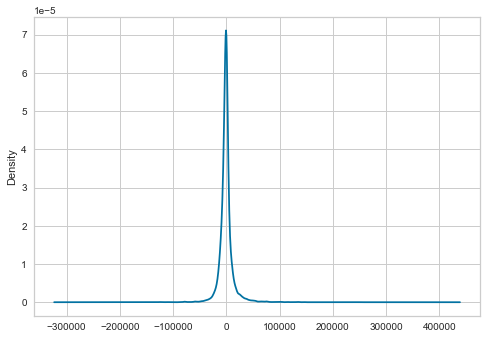

In [411]:
target.plot.kde()

<AxesSubplot:ylabel='Density'>

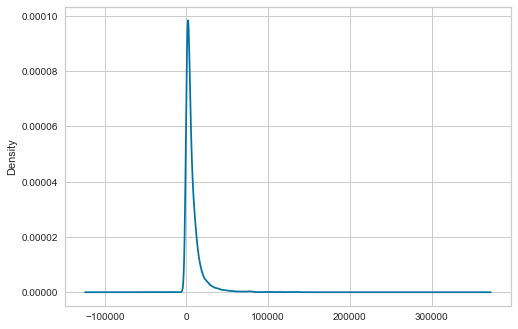

In [412]:
target.abs().plot.kde()

In [413]:
target.quantile(np.linspace(0, 1, num=11)).values

array([-132732. ,  -11043.3,   -6235.2,   -3604.3,   -1894. ,    -598. ,
           270. ,    1486.9,    3954.6,   10175.3,  248354. ])

In [414]:
[str(x) for x in target.quantile(np.linspace(0, 1, num=11)).values]

['-132732.0',
 '-11043.3',
 '-6235.2',
 '-3604.2999999999997',
 '-1894.0',
 '-598.0',
 '270.0',
 '1486.8999999999978',
 '3954.600000000002',
 '10175.300000000001',
 '248354.0']

In [415]:
target

0       -2814.0
1         222.0
2        -403.0
3         186.0
4       -2335.0
         ...   
9885     1448.0
9886    11527.0
9887     6989.0
9888     2968.0
9889     7326.0
Name: dem_net_vote, Length: 9890, dtype: float64

In [416]:
flips = sample[((sample['dem_net_vote'] < 0) & (sample['previous_winner_dem'] == True)) | ((sample['dem_net_vote'] > 0) & (sample['previous_winner_dem'] == False))]

flips

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Male,Female,White alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
1,2011.0,ms,l002,l002-0,222.0,0.0,l002,12084,12372,20339,...,2026,1993,867,417,547,4419,14154,4179,1.8,45.298111
3,2011.0,ms,l004,l004-0,186.0,0.0,l004,11638,11958,19342,...,2195,2050,750,218,557,4368,14207,3373,1.8,17.883455
8,2011.0,ms,l019,l019-0,-1888.0,1.0,l019,13687,14126,26402,...,3299,2588,1166,386,766,5212,17012,3611,1.8,42.756222
9,2011.0,ms,l020,l020-0,-848.0,1.0,l020,11291,12079,18753,...,2592,2004,950,501,904,3820,14387,3522,1.8,27.307452
12,2011.0,ms,l024,l024-0,142.0,0.0,l024,9163,10797,11505,...,1765,1757,881,230,671,3373,12161,3097,1.8,161.414222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9846,2016.0,ak,l024,l024-0,-1501.0,1.0,l024,8979,9332,13705,...,1274,1845,1770,829,3691,3110,11506,2371,0.6,231.041185
9853,2016.0,ak,l034,l034-0,195.0,0.0,l034,9237,8859,12868,...,1664,2283,1844,1115,2973,3309,12017,1770,0.6,7.515462
9882,2016.0,hi,l044,l044-0,1355.0,0.0,l044,13739,13816,3143,...,2354,2442,1130,466,1349,5274,16931,2974,0.6,124.590550
9884,2016.0,hi,l047,l047-0,108.0,0.0,l047,12991,12967,9605,...,1964,2801,1598,927,2541,4409,16131,3245,0.6,40.399913


In [417]:
flips.describe()

,year,dem_net_vote,previous_winner_dem,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
count,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,...,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000,1750.000000
mean,2013.702286,-116.685143,0.555429,35411.185143,36381.652571,56318.173714,5989.389714,759.441714,3502.851429,131.694286,...,6592.892571,7030.410286,4752.744000,1980.816571,6679.009143,12268.448000,45005.035429,10034.753714,-0.566743,481.499988
std,1.682978,9105.943129,0.497060,49415.682071,50575.137309,71830.268110,13569.140547,2524.036172,13239.166418,515.349002,...,8285.016881,8954.836542,6472.337226,2886.418963,12364.588967,17977.014093,63191.850818,13601.425099,1.240508,982.116058
min,2011.000000,-113145.000000,0.000000,1343.000000,1184.000000,2302.000000,0.000000,0.000000,0.000000,0.000000,...,238.000000,154.000000,110.000000,43.000000,94.000000,339.000000,1689.000000,381.000000,-2.400000,0.112356
25%,2012.000000,-1742.250000,0.000000,10310.000000,10324.250000,16240.000000,166.000000,45.250000,151.000000,0.000000,...,1862.500000,2036.500000,1259.000000,466.500000,1269.750000,3167.000000,12761.000000,2653.250000,-2.400000,27.060906
50%,2014.000000,-139.500000,1.000000,19576.000000,19812.500000,34247.500000,1080.500000,172.500000,551.000000,9.000000,...,3993.000000,4133.000000,2591.500000,1018.000000,2606.500000,6543.000000,23909.000000,5806.500000,-0.200000,120.086046
75%,2016.000000,986.000000,1.000000,41237.000000,42155.000000,67557.750000,5615.500000,504.250000,2073.500000,47.000000,...,8120.500000,8763.250000,5996.500000,2425.250000,6497.000000,14674.500000,52559.000000,12171.750000,0.600000,612.180933
max,2016.000000,80716.000000,1.000000,474913.000000,484692.000000,802638.000000,206724.000000,54231.000000,266080.000000,9373.000000,...,76875.000000,91593.000000,73475.000000,33250.000000,147779.000000,209879.000000,648903.000000,150712.000000,1.800000,16004.873133


In [418]:
pd.concat([sample, flips]).drop_duplicates(keep=False).describe()

,year,dem_net_vote,previous_winner_dem,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
count,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,...,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000,8140.000000
mean,2013.948526,-220.763391,0.429484,43379.809705,44716.560688,67137.625184,8389.469042,672.976290,4939.907371,166.918428,...,7855.759582,8451.775676,5871.231572,2471.238329,8826.014496,15046.069165,55235.960442,12294.799754,-0.555233,786.057674
std,1.675310,14977.148815,0.495033,54587.244235,56077.409368,78473.533394,18554.337510,1553.448132,16258.502339,658.577678,...,9014.366148,9591.279463,7058.175388,3178.192568,14891.209024,19782.151436,69871.094438,15227.791236,1.267617,2404.151560
min,2011.000000,-132732.000000,0.000000,1471.000000,1527.000000,1253.000000,0.000000,0.000000,0.000000,0.000000,...,234.000000,271.000000,112.000000,0.000000,38.000000,233.000000,1932.000000,320.000000,-2.400000,0.049948
25%,2012.000000,-5430.500000,0.000000,13525.250000,13711.000000,21456.250000,295.000000,71.000000,243.000000,0.000000,...,2614.500000,2854.500000,1890.750000,708.000000,1817.000000,4724.250000,16983.250000,3822.500000,-2.400000,30.457499
50%,2014.000000,-943.500000,0.000000,27514.500000,28291.500000,41414.500000,1596.000000,221.000000,824.000000,14.000000,...,5022.000000,5300.500000,3462.000000,1356.000000,3798.000000,9174.000000,34669.500000,7518.000000,-0.200000,164.221184
75%,2016.000000,3040.250000,1.000000,53535.250000,55498.250000,82804.500000,7680.750000,580.250000,3188.500000,61.000000,...,9373.500000,10322.750000,7210.000000,2991.250000,9423.000000,18129.000000,68052.000000,14831.250000,0.600000,765.700914
max,2016.000000,248354.000000,1.000000,493194.000000,505522.000000,813353.000000,324079.000000,52234.000000,341248.000000,16991.000000,...,81167.000000,93579.000000,76884.000000,36147.000000,247045.000000,209426.000000,672729.000000,179491.000000,1.800000,40044.021295


In [419]:
target1 = []

for value in target:
    if value < -2497.041195:
        target1.append(-1)
    elif value > 2497.041195:
        target1.append(1)
    else:
        target1.append(0)

In [420]:
pd.Series(target1).value_counts()

 0    3826
-1    3566
 1    2498
dtype: int64

In [421]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9890 entries, 0 to 9889
Data columns (total 46 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   year                                                          9890 non-null   float64
 1   state                                                         9890 non-null   object 
 2   temp_district                                                 9890 non-null   object 
 3   district                                                      9890 non-null   object 
 4   previous_winner_dem                                           9890 non-null   float64
 5   census_matching_temp_district                                 9890 non-null   object 
 6   Male                                                          9890 non-null   int64  
 7   Female                                                        9890 no

In [422]:
data = data.drop(['temp_district','district'], axis=1)

In [423]:
# ce.target_encoder.TargetEncoder().fit(X_train, y_train)

target_encoder = Pipeline(steps=[
    ('freq_enc', ce.target_encoder.TargetEncoder()),
#     ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
    
])

preprocessor = ColumnTransformer(
    transformers=[
#         ('num', num_transformer, num_cols),
#         ('ohe', ohe_transformer, cols_to_ohe),
        ('target', target_encoder, ['census_matching_temp_district', 'state'])
    ])
pipe = Pipeline([
    ('preprocessor', preprocessor)
#                         ('scaler', scaler),
#                         ('classifier', estimator)
])

x_trans = pipe.fit_transform(data, target1)



In [424]:
data['census_matching_temp_district'] = pd.DataFrame(x_trans)[0]
data['state'] = pd.DataFrame(x_trans)[1]

In [426]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

for i in np.linspace(10, 100, num=10):
    print('Percentile thresh: ' + str(i) + '\n')
    boruta = BorutaPy(
        estimator = RandomForestClassifier(), 
        n_estimators = 'auto', 
        perc = i
    ).fit(np.array(data), pd.Series(target1))
    
    green_area = data.columns[boruta.support_].to_list()
    blue_area = data.columns[boruta.support_weak_].to_list()
    print('features to keep:', green_area)
    print('features to consider removing:', blue_area)
    
    features_to_drop = []

    for each in data.columns:
        if each in data.columns[boruta.support_].to_list() or each in data.columns[boruta.support_weak_].to_list():
            pass
        else:
            features_to_drop.append(each)
#             print(each)
    print('features to remove:', features_to_drop, '\n')


Percentile thresh: 10.0

features to keep: ['state', 'previous_winner_dem', 'census_matching_temp_district', 'Male', 'Female', 'White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Native Hawaiian and Other Pacific Islander alone', 'Some other race alone', 'Two or more races:', 'Two races including Some other race', 'Two races excluding Some other race, and three or more races', 'U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'Speak only English', 'Speak Spanish', 'Speak other languages', 'Never married', 'Now married, except separated', 'Divorced', 'Separated', 'Widowed', 'Less than high school graduate', 'High school graduate (includes equivalency)', "Some college or associate's degree", "Bachelor's degree", 'Graduate or professional degree', 'No income', '$1 to $9,999 or loss', '$10,000 to $14,999', '$15,000 to $24,999', '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to 

features to keep: ['state', 'previous_winner_dem', 'census_matching_temp_district', 'Male', 'Female', 'White alone', 'Black or African American alone', 'American Indian and Alaska Native alone', 'Asian alone', 'Some other race alone', 'Two or more races:', 'Two races including Some other race', 'Two races excluding Some other race, and three or more races', 'U.S. citizen, born in the United States', 'U.S. citizen, born in Puerto Rico or U.S. Island Areas', 'Speak only English', 'Speak Spanish', 'Speak other languages', 'Never married', 'Now married, except separated', 'Divorced', 'Separated', 'Widowed', 'Less than high school graduate', 'High school graduate (includes equivalency)', "Some college or associate's degree", "Bachelor's degree", 'Graduate or professional degree', 'No income', '$1 to $9,999 or loss', '$10,000 to $14,999', '$15,000 to $24,999', '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $64,999', '$65,000 to $74,999', '$75,000 or more', '5 to 17 years', '18 to 64

In [427]:
data = data[green_area]

 0    3826
-1    3566
 1    2498
dtype: int64


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


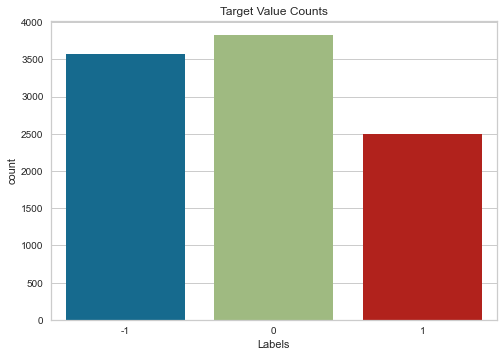

In [428]:
print(pd.Series(target1).value_counts())
sns.countplot(target1)
plt.xlabel('Labels')
plt.title('Target Value Counts')
plt.show()

In [429]:
#Minority Resampling - SMOTE

from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
print('Original dataset shape {}'.format(Counter(target1)))
sm = SMOTE()
X , y = sm.fit_resample(data, target1)
print('Resampled dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 3826, -1: 3566, 1: 2498})
Resampled dataset shape Counter({-1: 3826, 0: 3826, 1: 3826})


In [430]:
data

,state,previous_winner_dem,census_matching_temp_district,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Some other race alone,...,"$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,pop_density_km
0,-0.081301,0.0,-0.270000,11439,12209,22621,635,31,115,111,...,2859,2503,1912,1095,313,963,3836,14614,3852,22.940935
1,-0.081301,0.0,-0.053571,12084,12372,20339,3753,25,33,75,...,3695,2026,1993,867,417,547,4419,14154,4179,45.298111
2,-0.081301,0.0,0.000000,11604,12092,20887,2384,23,178,34,...,3230,2679,1994,890,259,491,4249,14465,3721,22.533774
3,-0.081301,0.0,0.087379,11638,11958,19342,3478,22,101,370,...,3377,2195,2050,750,218,557,4368,14207,3373,17.883455
4,-0.081301,0.0,-0.135135,12625,12944,18266,6364,75,281,383,...,3265,2492,2522,1109,463,1251,4200,16380,3386,17.301338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,0.528926,0.0,-0.288462,25767,27020,13216,354,140,26967,238,...,4396,4089,5248,4890,2644,11582,7085,30569,12742,400.785276
9886,0.528926,1.0,-0.021739,28926,30534,12459,581,56,29224,473,...,5693,5357,7486,5917,2275,7179,5911,39777,11191,2497.492557
9887,0.528926,1.0,-0.098039,27432,27714,6526,715,63,33736,429,...,6224,5615,6036,3961,1706,5470,6681,33366,12487,2091.452248
9888,0.528926,1.0,0.053571,30142,30250,12451,2525,135,24668,392,...,5685,5215,7159,4299,2372,6642,11041,38071,6277,699.054325


In [ ]:
# model runner


class ModelRunner():
    
    def __init__(self, pipe, X, y):
        self.X = X
        self.y = y
        self.pipe = pipe
#         if type(self.pipe[-1]) == LinearRegression:
#             self.model_type = 'linear'
#         else:
#             self.model_type = 'non_linear'
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, pd.Series(self.y), random_state = 42)
        
        self.pipe.fit(self.X_train, self.y_train)
        
#         train_preds = self.pipe.predict(self.X_train)
        test_preds = self.pipe.predict(self.X_test)
        
#         if self.model_type == 'linear':
        
#             print('Train Scores')
#             print('r2 score: ' + str(r2_score(self.y_train, train_preds)))
#             print('Mean absolute error: ' + str(mean_absolute_error(self.y_train, train_preds)))
#             print('Mean squared error: ' + str(mean_squared_error(self.y_train, train_preds)) + '\n')
            
#             print('Test Scores')
#             print('r2 score: ' + str(r2_score(self.y_test, test_preds)))
#             print('Mean absolute error: ' + str(mean_absolute_error(self.y_test, test_preds)))
#             print('Mean squared error: ' + str(mean_squared_error(self.y_test, test_preds)))
            
#             visualizer = PredictionError(self.pipe)
#             visualizer.fit(self.X_train, self.y_train)  
#             visualizer.score(self.X_test, self.y_test)  
#             visualizer.poof()
            
#             visualizer = ResidualsPlot(self.pipe)
#             visualizer.fit(self.X_train, self.y_train)  
#             visualizer.score(self.X_test, self.y_test)  
#             visualizer.poof()
            
#         elif self.model_type == 'non_linear':
#             train_preds = pipe.predict(self.X_train)
#             test_preds = pipe.predict(self.X_test)

#             train_out = pipe.predict_proba(self.X_train)
#             test_out = pipe.predict_proba(self.X_test)
            

#             ac = make_scorer(accuracy_score)
#             f1 = make_scorer(f1_score, average='macro')
#             ras = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)
#             rec = make_scorer(recall_score, average='weighted')
#             cv = cross_validate(self.pipe, self.X, self.y, scoring = {'accuracy': ac, 'recall': rec, 'f1_score':f1, 'roc_auc_score':ras})
#             for key, values in cv.items():
#                 if key.startswith('test_'):
#                     print(key[5:] + ': ' + str(values.mean()))
        self.cr = classification_report(self.y_test, test_preds, output_dict=True)
#         cv = cross_validate(self.pipe, self.X, self.y, scoring=('recall', 'precision'), return_estimator=True)
#         self.cr = {'recall': cv['test_recall'].max(), 'precision': cv['test_precision'].max()}
        visualizer = ROCAUC(self.pipe, classes = ['Democratic Win', 'Republican Win', 'Tossup'])

                # Fitting to the training data first then scoring with the test data

        visualizer.fit(self.X_train, self.y_train)
        visualizer.score(self.X_test, self.y_test)
        visualizer.show()


        ConfusionMatrixDisplay.from_predictions(self.y_test, test_preds)
        plt.show()
#         cm.plot()
#         plt.show()
#         print(confusion_matrix(self.y_test, test_preds))
#         plot_confusion_matrix(self.pipe, self.X_test, self.y_test, values_format=',.5g')



In [ ]:
lr = RandomForestClassifier()

# target_encoder = Pipeline(steps=[
#     ('freq_enc', ce.target_encoder.TargetEncoder()),
#     ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
    
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
# #         ('num', num_transformer, num_cols),
# #         ('ohe', ohe_transformer, cols_to_ohe),
#         ('target', target_encoder, ['district'])
#     ])

pipe = Pipeline([
#             ('preprocessor', preprocessor),
                         ('scaler', StandardScaler()),
                    ('lr', lr)])


cv = cross_validate(pipe, X, y, scoring=('recall_macro', 'precision_macro'), return_estimator=True)


In [ ]:
cv

In [ ]:
ModelRunner(pipe, X, y).cr

# ----------------------------------

In [ ]:
tree = DecisionTreeClassifier()

pipe = Pipeline([('scaler', StandardScaler()),
                    ('tree', tree)])

In [ ]:
ModelRunner(pipe, X, y).cr

# --------------------------------

In [ ]:
rf = RandomForestClassifier()

pipe = Pipeline([
                         ('scaler', StandardScaler()),
                    ('rf', rf)])

In [ ]:
ModelRunner(pipe, X, y)

# --------------------------

In [ ]:
svc = SVC(probability=True)

pipe = Pipeline([
                         ('scaler', StandardScaler()),
                    ('svc', svc)])

In [ ]:
ModelRunner(pipe, X, y)

# --------------------------

In [ ]:
ada = AdaBoostClassifier()

pipe = Pipeline([
                         ('scaler', StandardScaler()),
                    ('ada', ada)])

In [ ]:
ModelRunner(pipe, X, y)

In [ ]:
from sklearn.ensemble import *
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import *

ensamble_classifiers = [
    AdaBoostClassifier,
               BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
    RandomForestClassifier, 
#     StackingClassifier,
#     VotingClassifier,
    HistGradientBoostingClassifier, DecisionTreeClassifier, LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier, GaussianProcessClassifier
]

AdaBoostClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


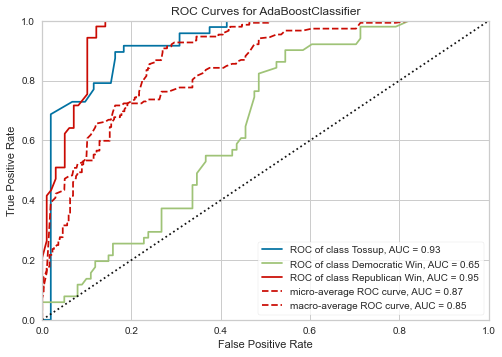

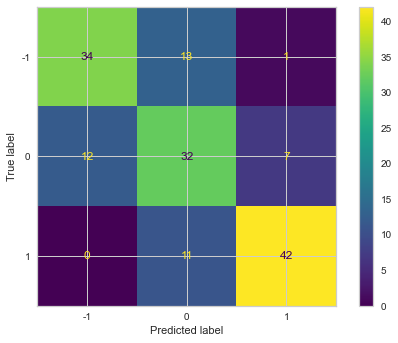

BaggingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


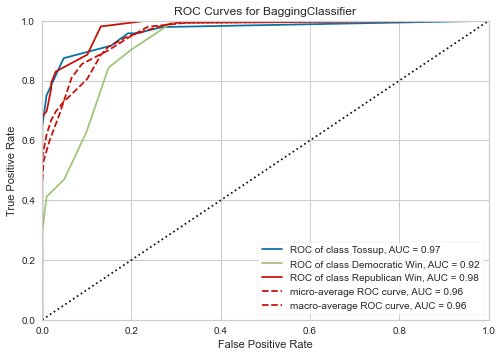

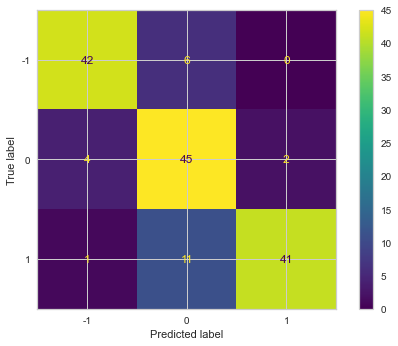

ExtraTreesClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


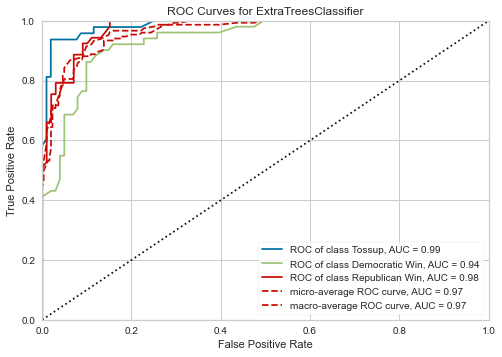

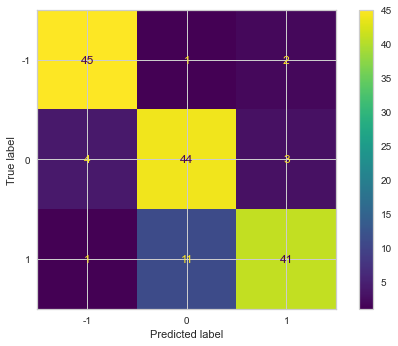

GradientBoostingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


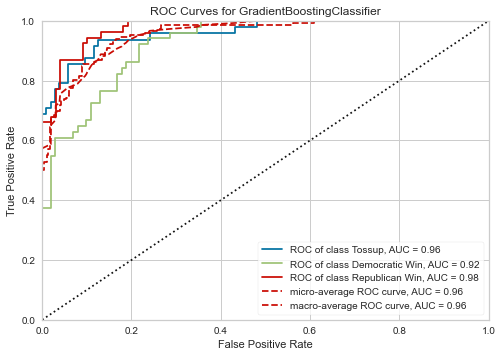

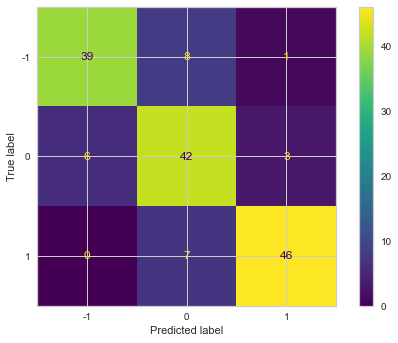

RandomForestClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


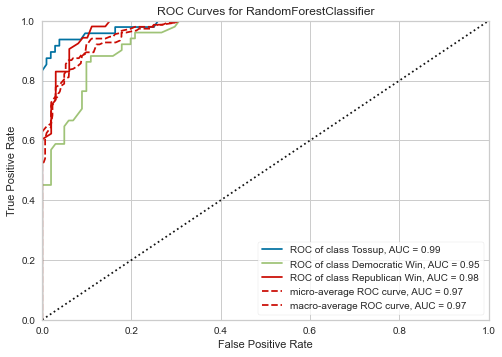

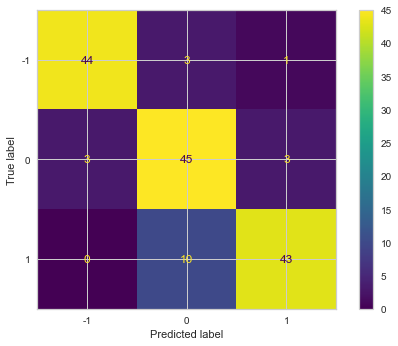

HistGradientBoostingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


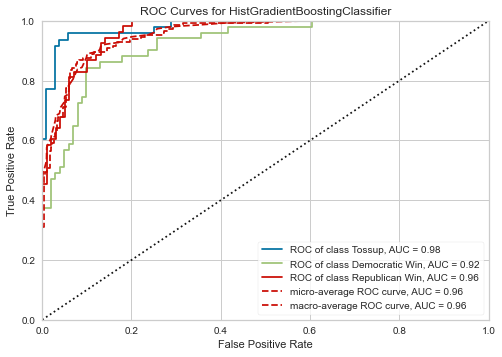

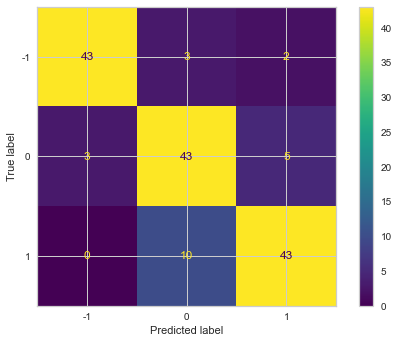

DecisionTreeClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


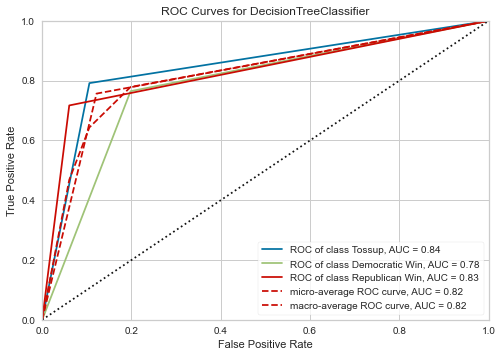

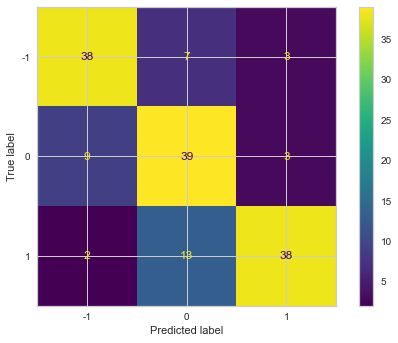

LogisticRegression


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


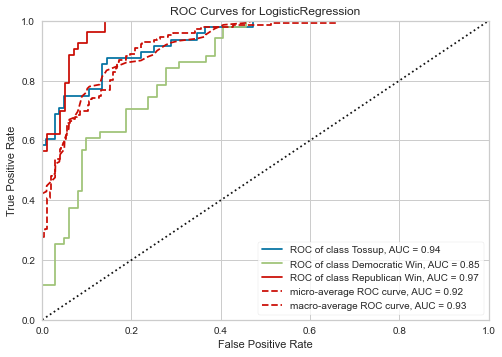

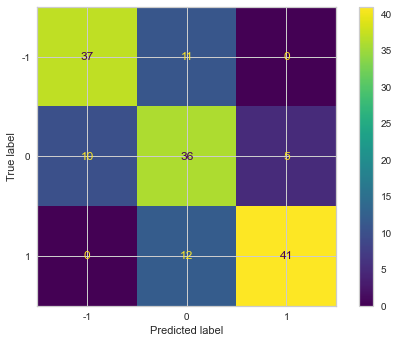

PassiveAggressiveClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


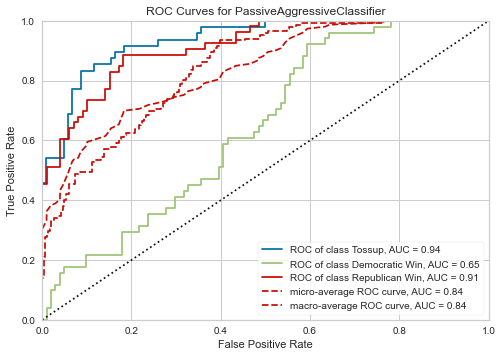

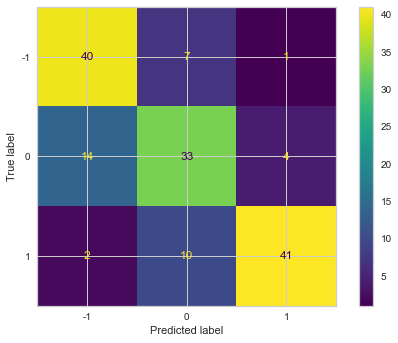

Perceptron


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


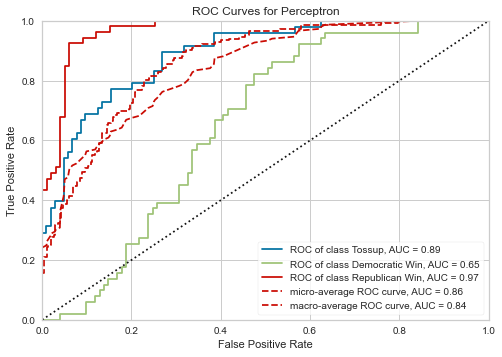

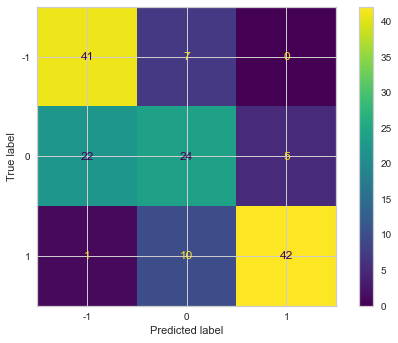

RidgeClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


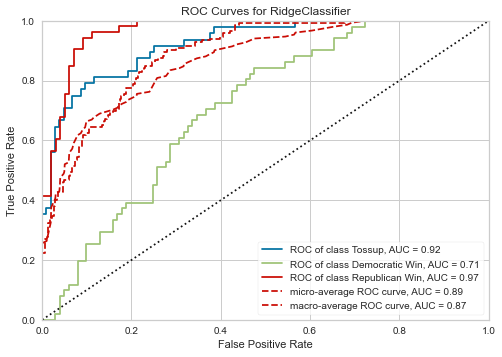

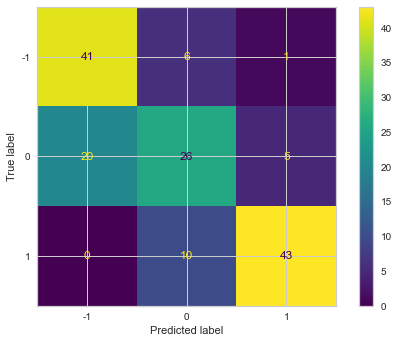

SGDClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


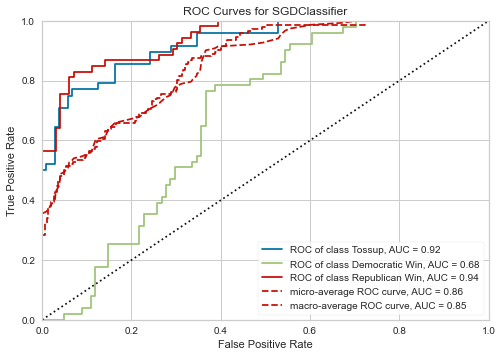

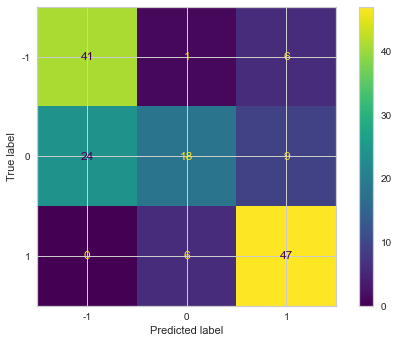

GaussianProcessClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


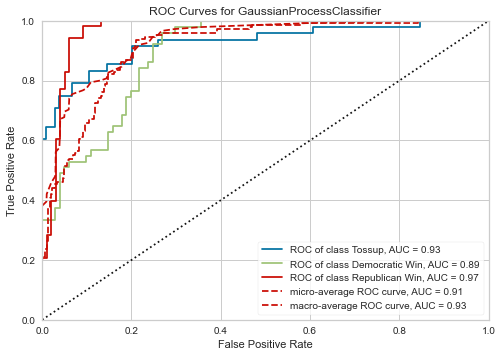

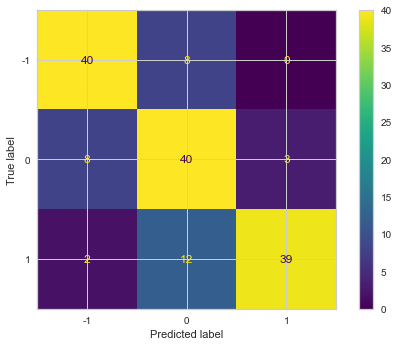

In [214]:
scores_df = pd.DataFrame()

for classifier in ensamble_classifiers:
    classifier_name = str(classifier).split('.')[-1][:-2]
    print(classifier_name)
    clf = classifier()

    pipe = Pipeline([('scaler', StandardScaler()),
                    ('clf', clf)])
    scores_df = scores_df.append(pd.Series(ModelRunner(pipe, X, y).cr['0'], name=classifier_name))

# Different models by state

ny
AdaBoostClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


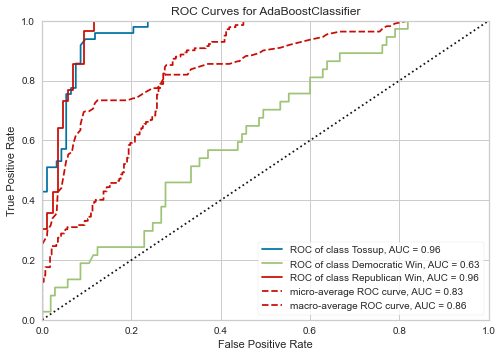

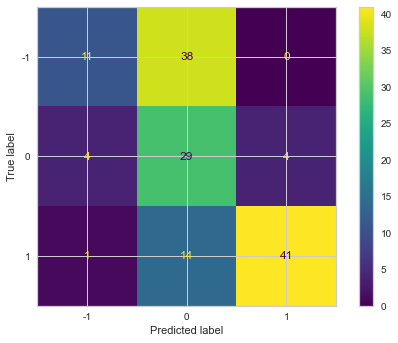

BaggingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


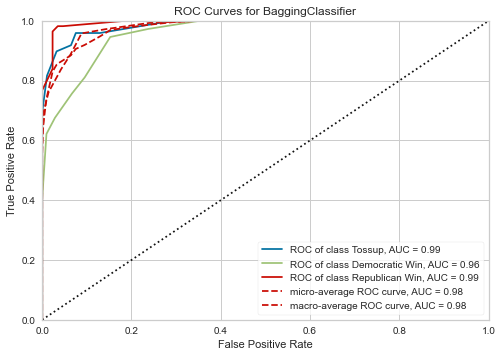

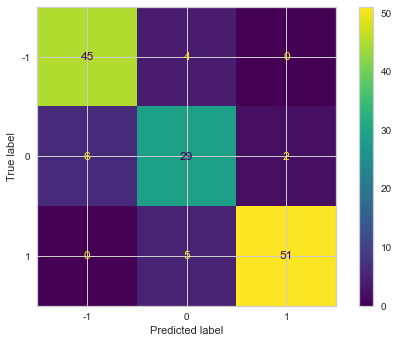

ExtraTreesClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


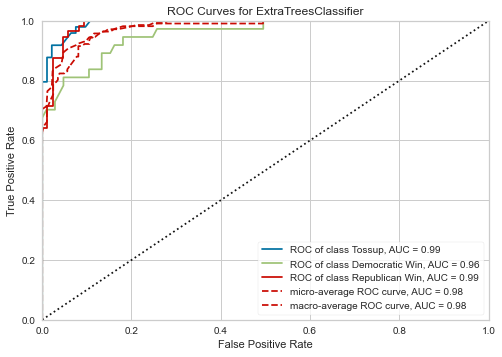

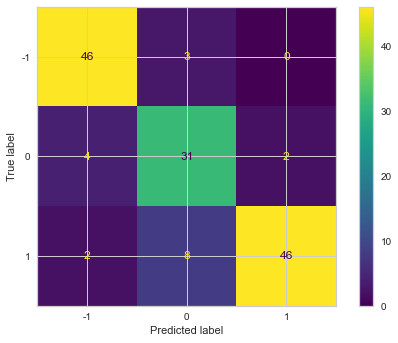

GradientBoostingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


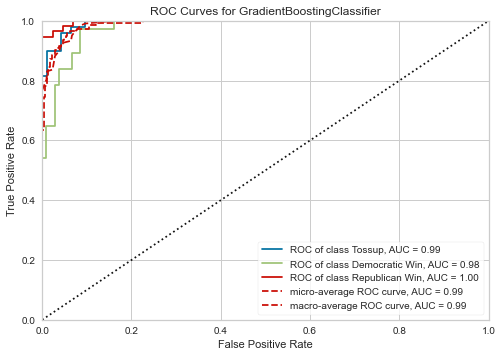

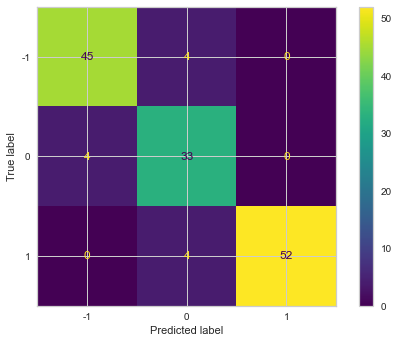

RandomForestClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


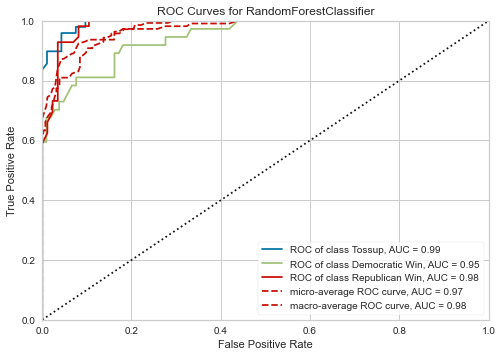

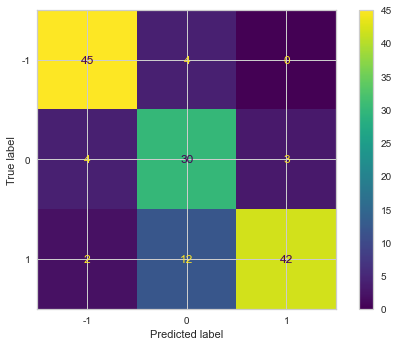

HistGradientBoostingClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


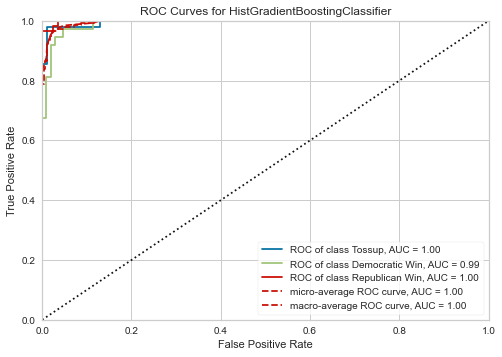

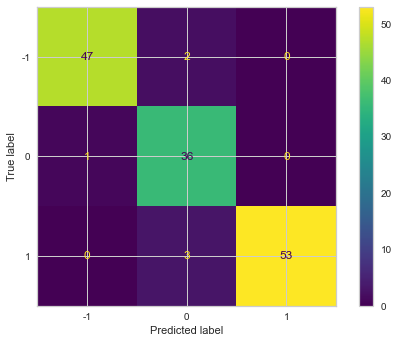

DecisionTreeClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


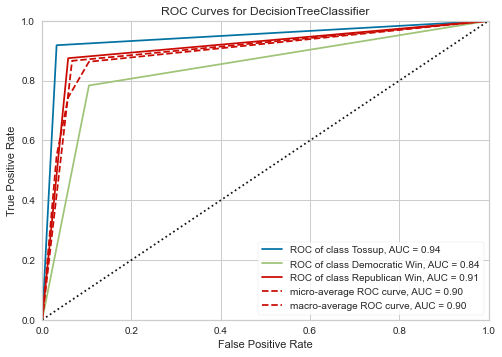

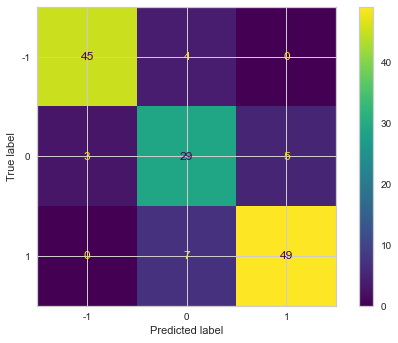

LogisticRegression


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


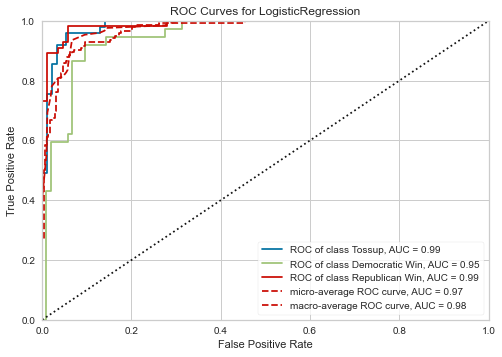

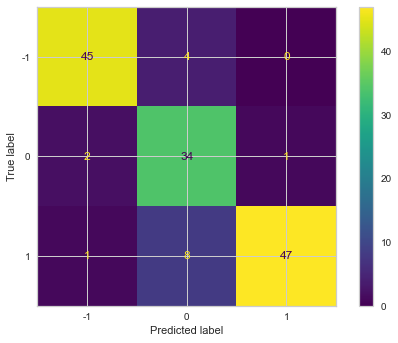

PassiveAggressiveClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


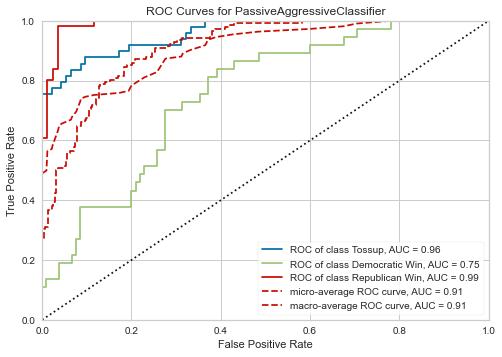

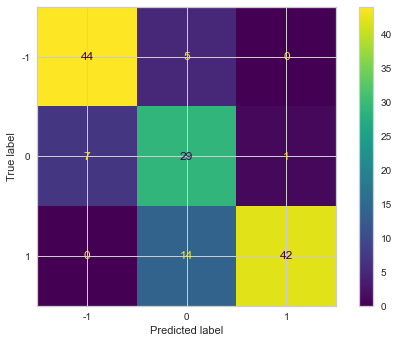

Perceptron


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


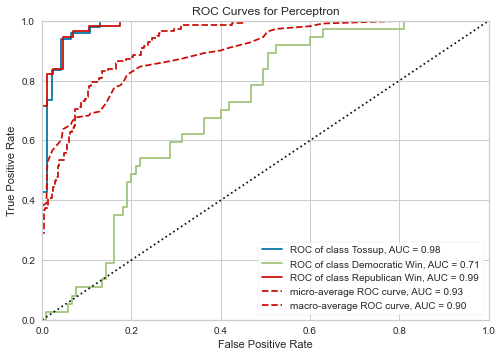

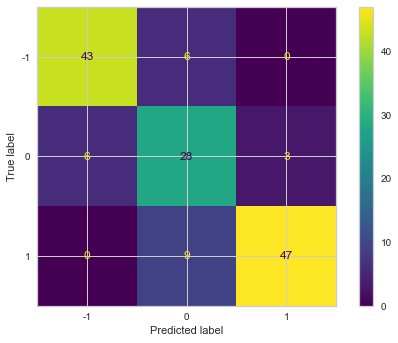

RidgeClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


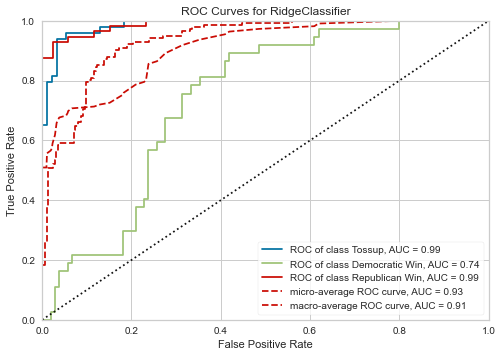

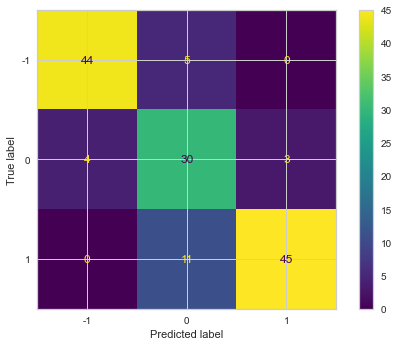

SGDClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


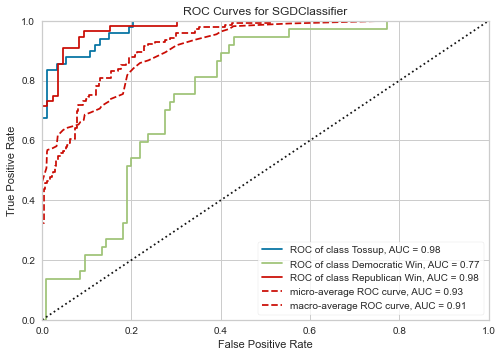

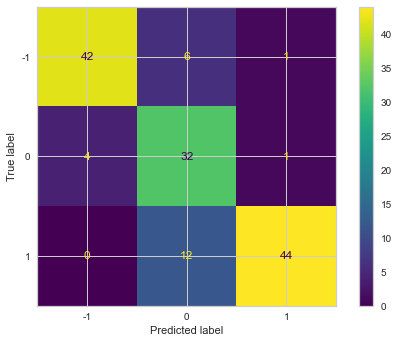

GaussianProcessClassifier


/Users/stone/.conda/envs/capstone4/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


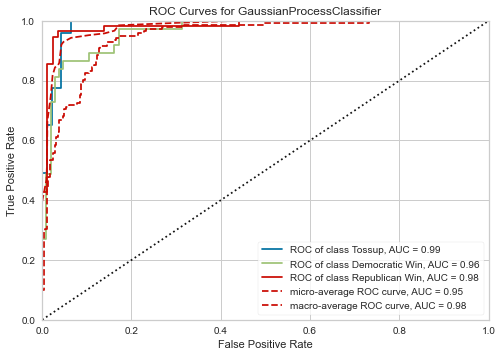

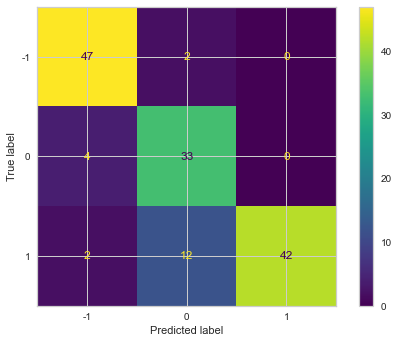

KeyboardInterrupt: Interrupted by user

In [371]:
# sample = sample.reset_index(drop=True)
states = sample['state'].unique()

for state in states:
    state = 'ny'
    print(state)
    temp_sample = sample[sample['state'] == state]
    data = temp_sample.drop(labels=['dem_net_vote', 'state'], axis=1)
    target = sample[sample['state'] == state]['dem_net_vote']
    data = data.drop(['temp_district','district'], axis=1)

    flips = temp_sample[((temp_sample['dem_net_vote'] < 0) & (temp_sample['previous_winner_dem'] == True)) | ((temp_sample['dem_net_vote'] > 0) & (temp_sample['previous_winner_dem'] == False))]
    
    target1 = []

    for value in target:
        if value < -flips['dem_net_vote'].std():
            target1.append(-1)
        elif value > flips['dem_net_vote'].std():
            target1.append(1)
        else:
            target1.append(0)
    

    target_encoder = Pipeline(steps=[
        ('freq_enc', ce.target_encoder.TargetEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('target', target_encoder, ['census_matching_temp_district'])
        ])
    pipe = Pipeline([
        ('preprocessor', preprocessor)
    ])

    x_trans = pipe.fit_transform(data, target1)



    data['census_matching_temp_district'] = x_trans    
    
    boruta = BorutaPy(
            estimator = RandomForestClassifier(), 
            n_estimators = 'auto', 
            perc=70
        ).fit(np.array(data), pd.Series(target1))

    green_area = data.columns[boruta.support_].to_list()
    
    data = data[green_area]
    
    try:
        sm = SMOTE(random_state=42)
        X , y = sm.fit_resample(data, target1)
    except ValueError:
        ros = RandomOverSampler(random_state=42)
        X, y = ros.fit_resample(data, target1)

    for classifier in ensamble_classifiers:
        classifier_name = str(classifier).split('.')[-1][:-2]
        print(classifier_name)
        clf = classifier()

        pipe = Pipeline([('scaler', StandardScaler()),
                        ('clf', clf)])
        scores_df = scores_df.append(pd.Series({**ModelRunner(pipe, X, y).cr['0'], 'state': state, 'relevant_features': green_area}, name=classifier_name))
        
    input()

In [373]:
scores_df[scores_df['state'] == 'ny']

,precision,recall,f1-score,support,relevant_features,state
AdaBoostClassifier,0.580000,0.568627,0.574257,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
BaggingClassifier,0.701754,0.784314,0.740741,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
ExtraTreesClassifier,0.792453,0.823529,0.807692,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
GradientBoostingClassifier,0.701754,0.784314,0.740741,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
RandomForestClassifier,0.759259,0.803922,0.780952,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
HistGradientBoostingClassifier,0.727273,0.784314,0.754717,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
DecisionTreeClassifier,0.622951,0.745098,0.678571,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
LogisticRegression,0.614035,0.686275,0.648148,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
PassiveAggressiveClassifier,0.500000,0.176471,0.260870,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
Perceptron,0.537500,0.843137,0.656489,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny


In [364]:
green_area

['previous_winner_dem',
 'census_matching_temp_district',
 'Female',
 'White alone',
 'Black or African American alone',
 'Asian alone',
 'Native Hawaiian and Other Pacific Islander alone',
 'Some other race alone',
 'Two or more races:',
 'Two races including Some other race',
 'U.S. citizen, born in the United States',
 'U.S. citizen, born in Puerto Rico or U.S. Island Areas',
 'Speak only English',
 'Speak Spanish',
 'Speak other languages',
 'Never married',
 'Now married, except separated',
 'Divorced',
 'Separated',
 'Widowed',
 'Less than high school graduate',
 'High school graduate (includes equivalency)',
 "Some college or associate's degree",
 'No income',
 '$1 to $9,999 or loss',
 '$35,000 to $49,999',
 '$50,000 to $64,999',
 '$65,000 to $74,999',
 '5 to 17 years',
 '18 to 64 years',
 '65 years and over',
 'generic_ballot',
 'pop_density_km']

In [249]:
X

,previous_winner_dem,census_matching_temp_district,White alone,Black or African American alone,Some other race alone,"U.S. citizen, born in the United States","U.S. citizen, born in Puerto Rico or U.S. Island Areas",Speak only English,Speak Spanish,Never married,"Now married, except separated",Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,pop_density_km
0,0.000000,-0.847241,115303,4177,2162,114202,457,105624,5554,26041,58605,6507,25621,25248,71.828398
1,0.000000,-0.260043,108201,11606,3227,114131,1210,98242,14644,33319,51413,9295,32858,24666,450.187729
2,1.000000,0.620754,102795,7567,4337,108017,578,97202,8424,36072,54098,5118,21110,22537,280.363855
3,0.000000,-0.260043,116397,2877,3543,114485,1023,103946,8332,31990,56383,7825,28362,27951,1292.464320
4,1.000000,0.441237,66302,24827,28258,76594,4493,50822,61177,41867,44966,22205,27957,18136,2295.633440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,0.000000,0.033556,94803,14782,7002,103685,868,92936,17734,34296,54941,7264,21429,21643,2576.655158
602,0.000000,-0.265350,117301,2681,2710,115359,819,103793,9089,33615,56760,6639,29279,27488,1274.566364
603,0.506106,0.033556,105453,7055,8562,105255,662,94340,14150,32295,56336,7814,19221,20231,761.138642
604,1.000000,0.620754,79796,30932,11751,98196,801,85120,19819,38261,48332,13239,28597,22359,1640.292629


In [247]:
data

,year,previous_winner_dem,census_matching_temp_district,Male,Female,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
2214,2012.0,0.0,l002,61397,64589,115303,4177,107,2216,158,...,10044,11740,10047,5204,22357,20553,74496,23499,-0.2,71.828398
2215,2012.0,0.0,l003,63192,66323,108201,11606,172,3762,67,...,10018,13421,11070,4762,14870,23420,83478,13824,-0.2,450.187729
2216,2012.0,1.0,l004,63694,64639,102795,7567,472,10490,0,...,8766,10354,8516,4879,21665,22277,82614,16207,-0.2,280.363855
2217,2012.0,0.0,l005,64977,65315,116397,2877,137,5381,0,...,9629,12619,10676,5650,18883,24649,83642,14932,-0.2,1292.464320
2218,2012.0,1.0,l006,65399,65199,66302,24827,842,4857,47,...,12379,13638,8692,2722,7314,24889,84901,11359,-0.2,2295.633440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,2016.0,1.0,u030,159142,184540,103552,151427,1990,21064,156,...,24615,26134,19476,8515,38652,46896,235010,40500,0.6,35277.071931
8830,2016.0,1.0,u031,160793,172583,152334,41823,2260,15220,235,...,24941,25585,19537,8397,43910,38892,231059,45809,0.6,14745.807025
8831,2016.0,1.0,u037,152613,165897,243054,20828,855,17918,74,...,20799,22644,22171,11046,66864,54194,194534,52359,0.6,796.511435
8832,2016.0,0.0,u056,139436,150234,207111,53681,1667,11859,100,...,31496,31158,20495,7463,19964,45842,182018,45007,0.6,178.562574


In [218]:
best_models = pd.DataFrame()

for state in states:
    row = scores_df[scores_df['state'] == state].sort_values(['recall', 'precision', 'f1-score'], ascending=False).iloc[0]
    best_models = best_models.append(row)

best_models = best_models.append(scores_df[scores_df['state'].isna()].sort_values(['recall', 'precision', 'f1-score'], ascending=False).iloc[0])

In [219]:
best_models.sort_values('recall', ascending=False)

,precision,recall,f1-score,support,relevant_features,state
ExtraTreesClassifier,0.933333,1.000000,0.965517,28.0,"[previous_winner_dem, census_matching_temp_dis...",nj
RandomForestClassifier,0.900000,1.000000,0.947368,9.0,"[previous_winner_dem, census_matching_temp_dis...",nv
DecisionTreeClassifier,1.000000,1.000000,1.000000,14.0,"[Male, Female, Now married, except separated, ...",al
ExtraTreesClassifier,1.000000,1.000000,1.000000,10.0,"[census_matching_temp_district, White alone, B...",az
BaggingClassifier,1.000000,1.000000,1.000000,27.0,"[Separated, Less than high school graduate, $1...",vt
RandomForestClassifier,1.000000,1.000000,1.000000,19.0,"[census_matching_temp_district, White alone, A...",ak
BaggingClassifier,0.777778,1.000000,0.875000,14.0,"[previous_winner_dem, census_matching_temp_dis...",wy
HistGradientBoostingClassifier,0.916667,0.970588,0.942857,34.0,"[previous_winner_dem, census_matching_temp_dis...",wi
ExtraTreesClassifier,1.000000,0.967480,0.983471,123.0,"[previous_winner_dem, census_matching_temp_dis...",nh
SGDClassifier,0.876923,0.966102,0.919355,59.0,"[census_matching_temp_district, Male, Female, ...",ks


In [220]:
scores_df[scores_df['state'] == 'ny']

,precision,recall,f1-score,support,relevant_features,state
AdaBoostClassifier,0.580000,0.568627,0.574257,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
BaggingClassifier,0.701754,0.784314,0.740741,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
ExtraTreesClassifier,0.792453,0.823529,0.807692,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
GradientBoostingClassifier,0.701754,0.784314,0.740741,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
RandomForestClassifier,0.759259,0.803922,0.780952,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
HistGradientBoostingClassifier,0.727273,0.784314,0.754717,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
DecisionTreeClassifier,0.622951,0.745098,0.678571,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
LogisticRegression,0.614035,0.686275,0.648148,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
PassiveAggressiveClassifier,0.500000,0.176471,0.260870,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny
Perceptron,0.537500,0.843137,0.656489,51.0,"[previous_winner_dem, census_matching_temp_dis...",ny


In [189]:
for state in states:
    print(scores_df[scores_df['state'] == state])
    break

precision    0.714286
recall       0.916667
f1-score     0.769231
support          12.0
state              ms
dtype: object


In [252]:
sample

,year,state,temp_district,district,dem_net_vote,previous_winner_dem,census_matching_temp_district,Male,Female,White alone,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $64,999","$65,000 to $74,999","$75,000 or more",5 to 17 years,18 to 64 years,65 years and over,generic_ballot,pop_density_km
0,2011.0,ms,l001,l001-0,-2814.0,0.0,l001,11439,12209,22621,...,2503,1912,1095,313,963,3836,14614,3852,1.8,22.940935
1,2011.0,ms,l002,l002-0,222.0,1.0,l002,12084,12372,20339,...,2026,1993,867,417,547,4419,14154,4179,1.8,45.298111
2,2011.0,ms,l003,l003-0,-403.0,1.0,l003,11604,12092,20887,...,2679,1994,890,259,491,4249,14465,3721,1.8,22.533774
3,2011.0,ms,l004,l004-0,186.0,1.0,l004,11638,11958,19342,...,2195,2050,750,218,557,4368,14207,3373,1.8,17.883455
4,2011.0,ms,l010,l010-0,-2335.0,1.0,l010,12625,12944,18266,...,2492,2522,1109,463,1251,4200,16380,3386,1.8,17.301338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,2016.0,hi,u009,u009-0,1448.0,0.0,u009,25767,27020,13216,...,4089,5248,4890,2644,11582,7085,30569,12742,0.6,400.785276
9941,2016.0,hi,u011,u011-0,11527.0,1.0,u011,28926,30534,12459,...,5357,7486,5917,2275,7179,5911,39777,11191,0.6,2497.492557
9942,2016.0,hi,u013,u013-0,6989.0,1.0,u013,27432,27714,6526,...,5615,6036,3961,1706,5470,6681,33366,12487,0.6,2091.452248
9943,2016.0,hi,u019,u019-0,2968.0,1.0,u019,30142,30250,12451,...,5215,7159,4299,2372,6642,11041,38071,6277,0.6,699.054325
